# **Tree decision**

## **1. Importación de librerías y carga del dataset**

#### **1.1. Importación de librerías**

In [52]:
# Análisis de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de sticky-learn para modelado
from sklearn.model_selection import train_test_split, GridSearchCV, KFold  # Para división de datos y validación
from sklearn.linear_model import Ridge                
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Para preprocesamiento
from sklearn.compose import ColumnTransformer          # Para aplicar transformaciones a columnas específicas
from sklearn.pipeline import Pipeline                  # Para encadenar pasos de preprocesamiento y modelado
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Métricas de evaluación

# Otras utilidades
import math
import warnings
warnings.filterwarnings("ignore") # Ignorar advertencias

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('viridis')

# Actualizar importaciones para incluir árboles de decisión y validación
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
import joblib  # Para guardar los modelos entrenados
from scipy import stats  # Para estadísticas adicionales

#### **1.2. Cargar el dataset**

In [53]:
df = pd.read_csv('../data/train_es_clean.csv')

# Mostramos información básica sobre el dataset
print(f"Dimensiones del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

# Visualizamos primeras filas
print("\nVisualización de las primeras filas:")
display(df.head())

Dimensiones del dataset: (1460, 81)
Número de filas: 1460
Número de columnas: 81

Visualización de las primeras filas:


,Id,TipoDeClaseMS,ZonificaciónMS,FrenteLote,ÁreaLote,Calle,Callejón,FormaLote,ContornoTerreno,Servicios,...,ÁreaPiscina,CalidadPiscina,Cerca,CaracterísticaExtra,ValorExtra,MesVenta,AñoVenta,TipoVenta,CondiciónVenta,PrecioVenta
0,1,60,RL,65.0,8450,Pave,NoTiene,Reg,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NoTiene,Reg,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NoTiene,IR1,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NoTiene,IR1,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NoTiene,IR1,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,12,2008,WD,Normal,250000


## **2. Exploración inicial de los datos**

In [35]:
# Seleccionamos las variables categóricas con cardinalidad moderada para comenzar
# Esto evita generar demasiadas columnas con el endcoding

vars_cat_seleccionadas = ['Vecindario', 'ZonificaciónMS', 'TipoEdificio', 'EstiloCasa', 'CalidadExterior', 'TipoGaraje']

Resumen estadístico de variables numéricas:


,Id,TipoDeClaseMS,FrenteLote,ÁreaLote,CalidadGeneral,CondiciónGeneral,AñoConstrucción,AñoRenovación,ÁreaRevestimientoMampostería,MetrosAcabadosSótano1,...,MetrosDeckMadera,MetrosPorcheAbierto,MetrosPorcheCerrado,MetrosPorche3Estaciones,MetrosPorcheMalla,ÁreaPiscina,ValorExtra,MesVenta,AñoVenta,PrecioVenta
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,41.215461,...,8.755599,4.334879,2.039603,0.316761,1.399208,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,42.372881,...,11.644350,6.155384,5.678152,2.723668,5.180031,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,35.628300,...,0.000000,2.322575,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,66.170162,...,15.607704,6.317404,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,524.344532,...,79.617871,50.817941,51.282456,47.194724,44.593440,738.000000,15500.000000,12.000000,2010.000000,755000.000000



Verificación de valores nulos:
Series([], dtype: int64)


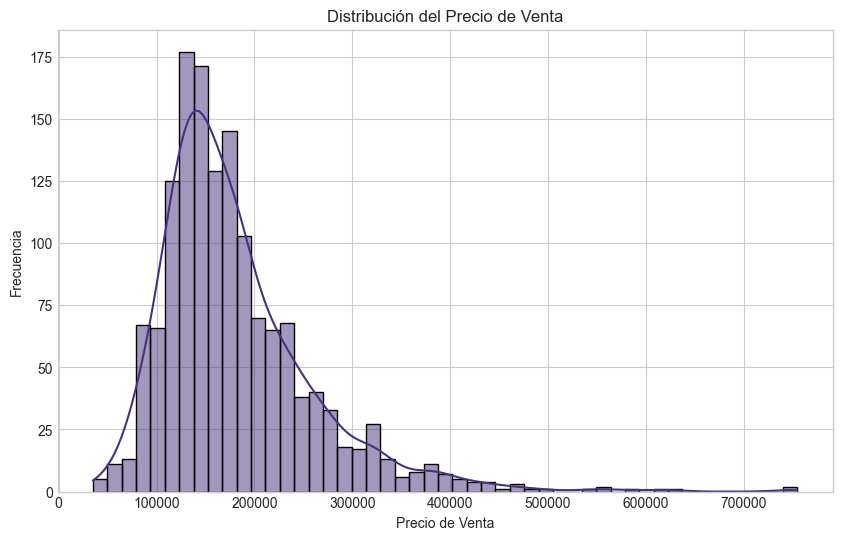

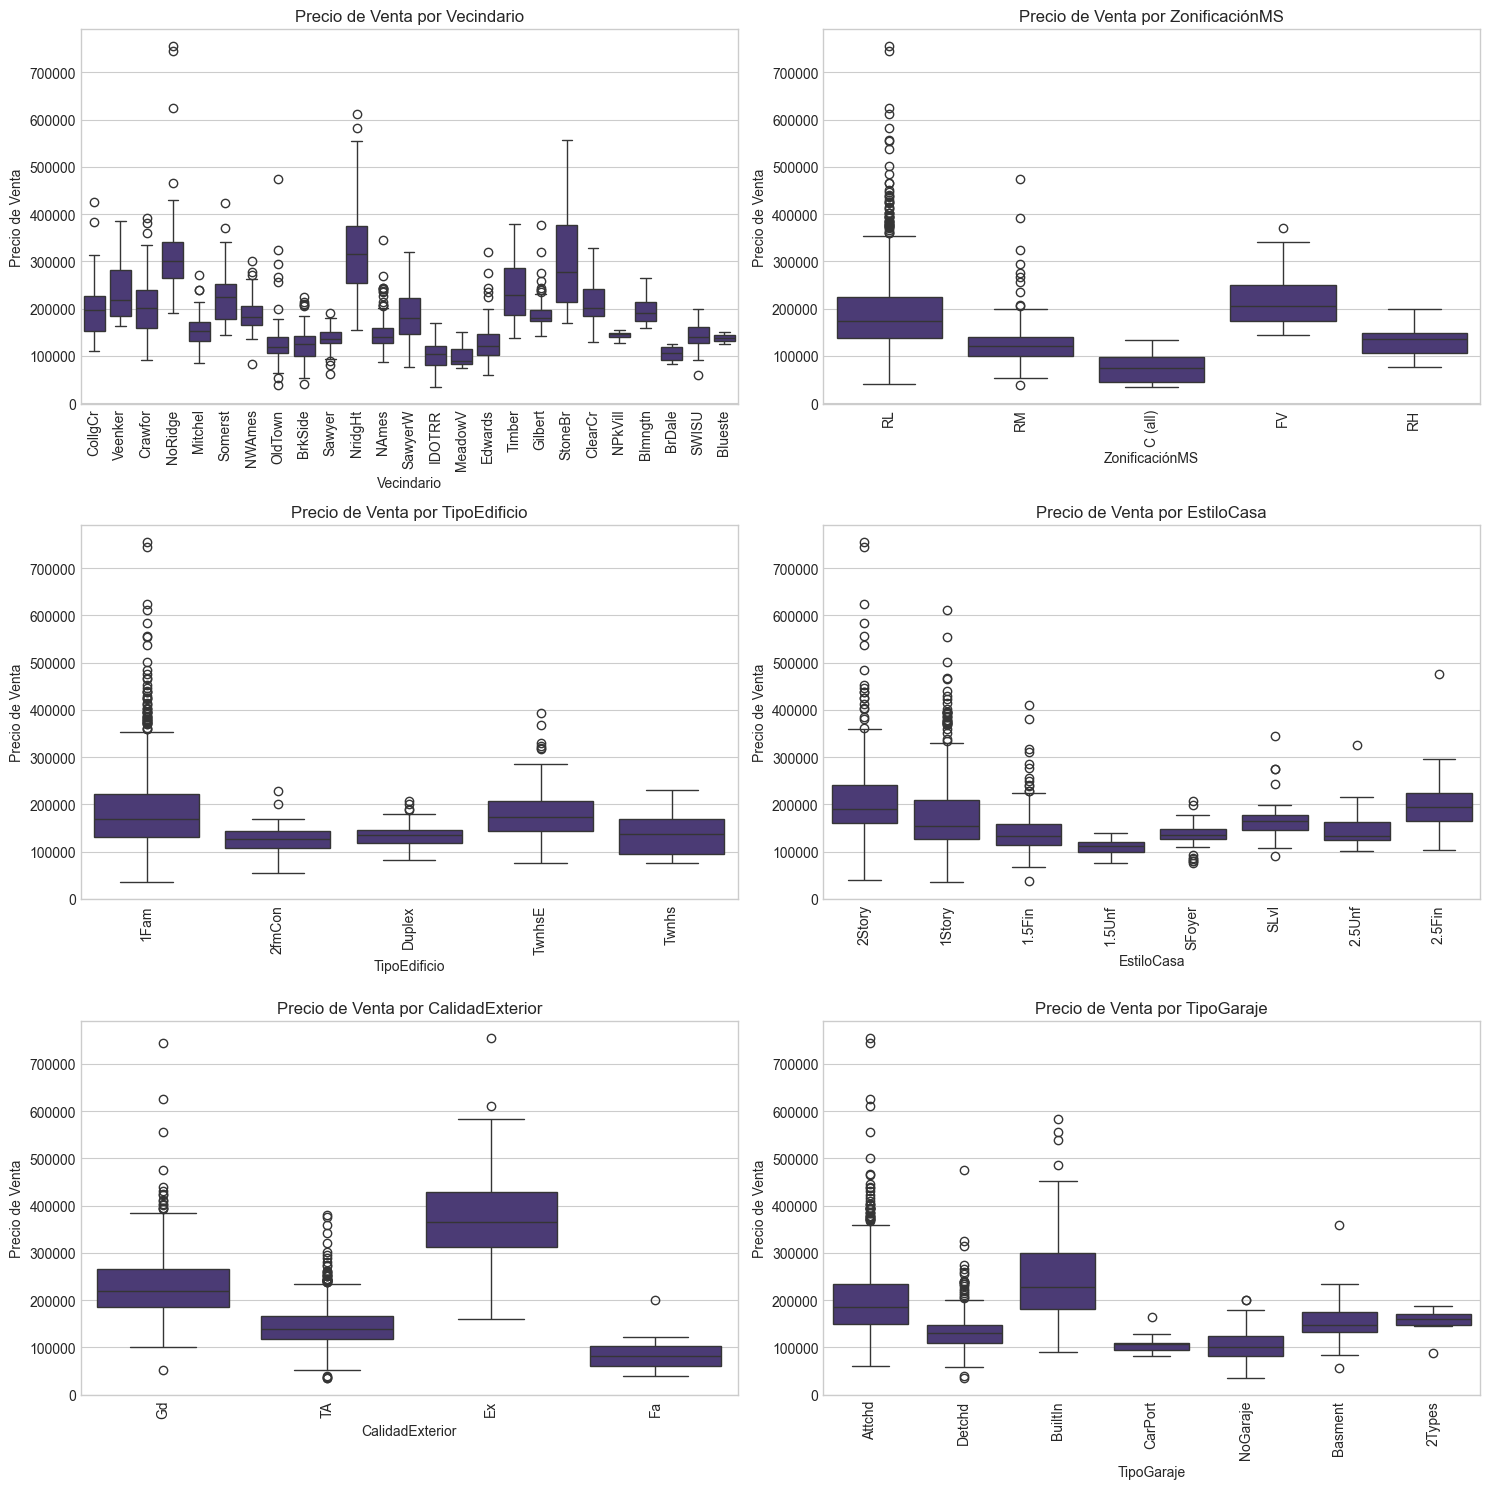

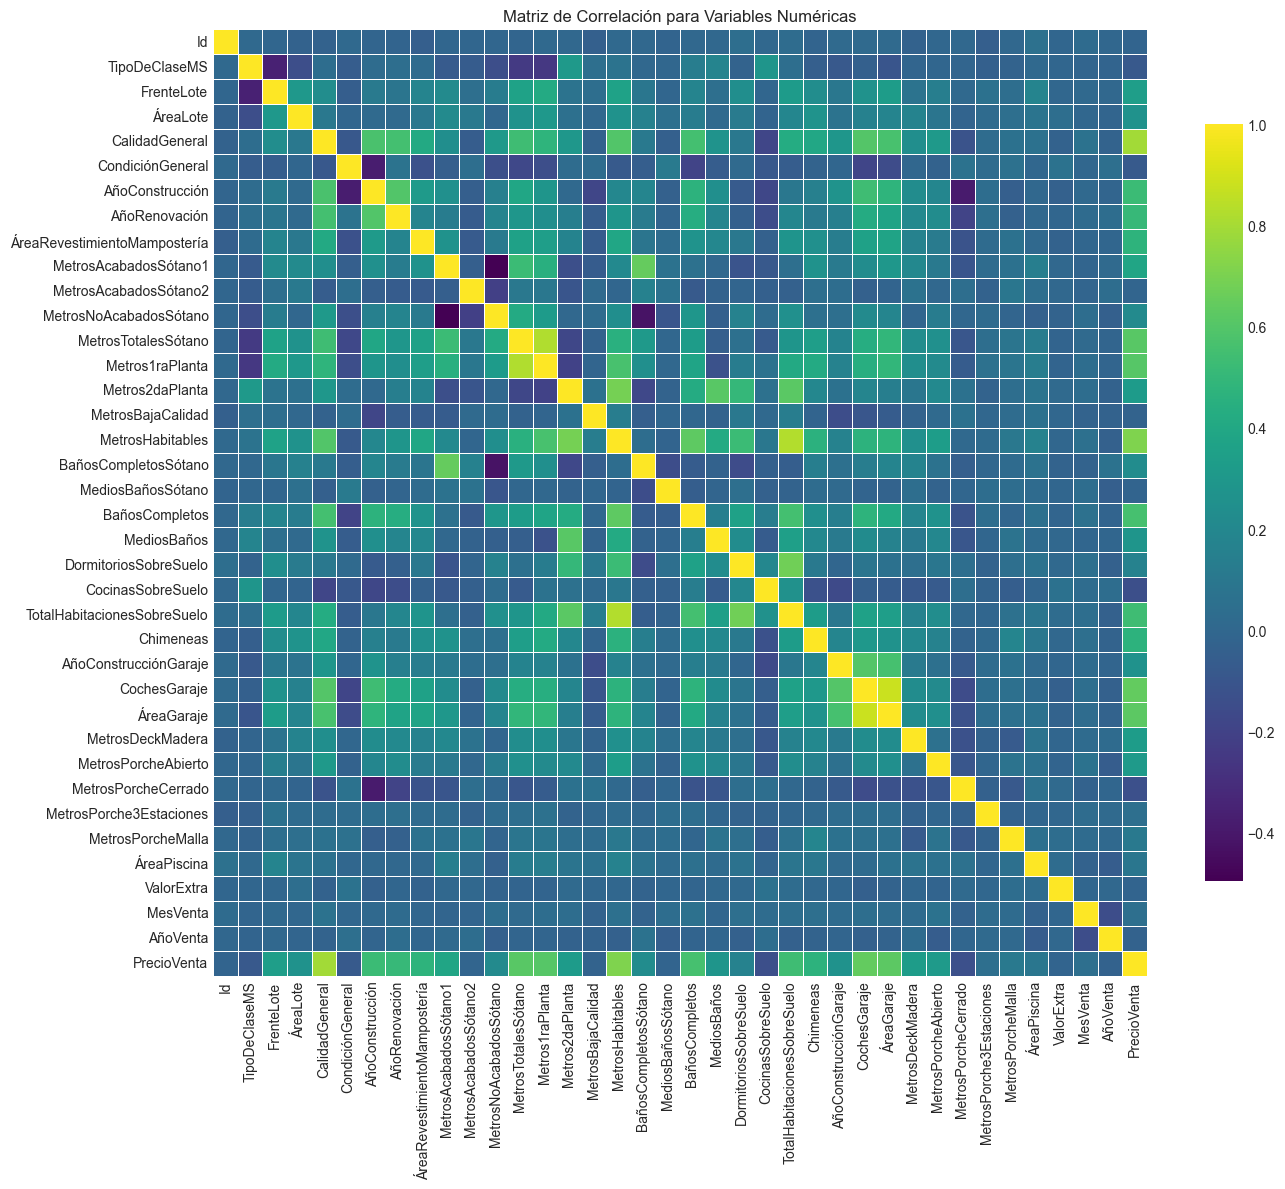


Top 10 características con mayor correlación con el Precio de Venta:
CalidadGeneral                 0.790982
MetrosHabitables               0.708624
CochesGaraje                   0.640409
ÁreaGaraje                     0.623431
MetrosTotalesSótano            0.613581
Metros1raPlanta                0.605852
BañosCompletos                 0.560664
TotalHabitacionesSobreSuelo    0.533723
AñoConstrucción                0.522897
AñoRenovación                  0.507101
Name: PrecioVenta, dtype: float64


In [54]:
# Información estadística detallada del dataset
print("Resumen estadístico de variables numéricas:")
display(df.describe())

# Verificar valores nulos
print("\nVerificación de valores nulos:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Visualizar la distribución de la variable objetivo (PrecioVenta)
plt.figure(figsize=(10, 6))
sns.histplot(df['PrecioVenta'], kde=True)
plt.title('Distribución del Precio de Venta')
plt.xlabel('Precio de Venta')
plt.ylabel('Frecuencia')
plt.show()

# Visualizar la relación entre variables categóricas seleccionadas y el precio de venta
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, var in enumerate(vars_cat_seleccionadas):
    sns.boxplot(x=var, y='PrecioVenta', data=df, ax=axes[i])
    axes[i].set_title(f'Precio de Venta por {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Precio de Venta')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Matriz de correlación para variables numéricas
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='viridis', 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación para Variables Numéricas')
plt.tight_layout()
plt.show()

# Top 10 características con mayor correlación con el precio de venta
precio_correlations = correlation_matrix['PrecioVenta'].sort_values(ascending=False)
print("\nTop 10 características con mayor correlación con el Precio de Venta:")
print(precio_correlations[1:11])  # Excluyendo la correlación consigo misma

## **3. Preparación de los Datos**

Número de variables categóricas: 43
Número de variables numéricas: 36


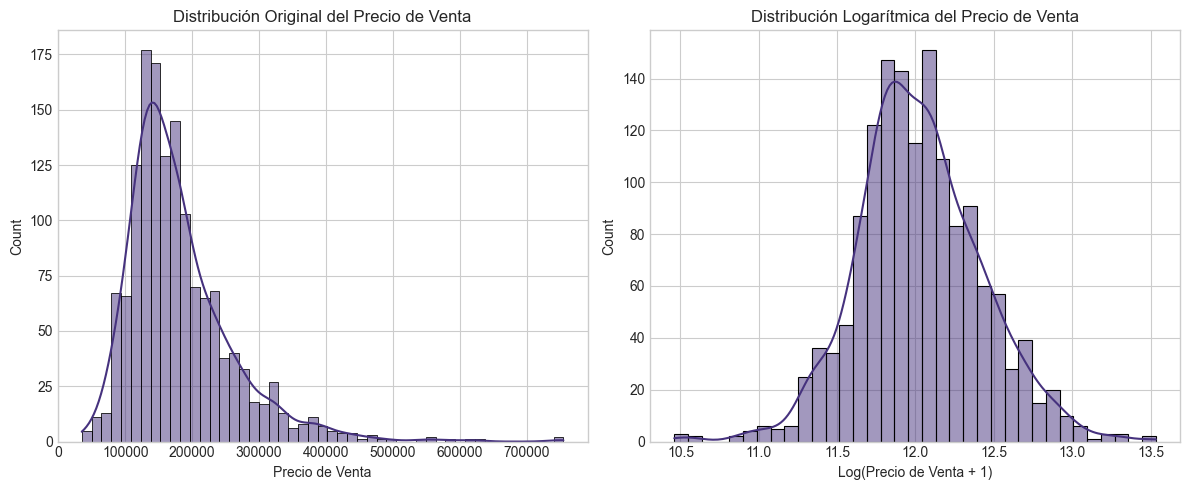

Variables numéricas con asimetría significativa: 22
['TipoDeClaseMS', 'FrenteLote', 'ÁreaLote', 'ÁreaRevestimientoMampostería', 'MetrosAcabadosSótano1'] ...


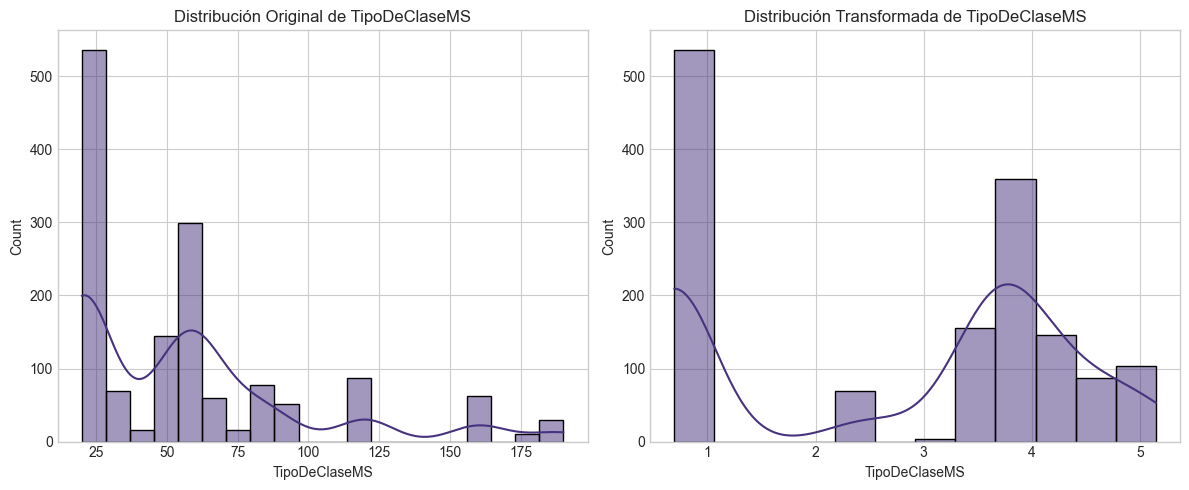

Forma de los datos de entrenamiento procesados: (1168, 90)
Forma de los datos de prueba procesados: (292, 90)


In [55]:
# Identificar variables categóricas y numéricas
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
num_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_columns.remove('Id')  # Eliminar la columna Id
num_columns.remove('PrecioVenta')  # Eliminar la variable objetivo

print(f"Número de variables categóricas: {len(cat_columns)}")
print(f"Número de variables numéricas: {len(num_columns)}")

# Para simplificar, usaremos solo las variables categóricas seleccionadas
X_cat = df[vars_cat_seleccionadas]
X_num = df[num_columns]
y = df['PrecioVenta']

# Aplicar transformación logarítmica a la variable objetivo para manejar la asimetría de precios
# Esto ayuda a que el modelo maneje mejor la gran diferencia entre precios altos y bajos
y_log = np.log1p(y)  # log1p = log(1+x) evita problemas con valores cero

# Visualizar la distribución antes y después de la transformación logarítmica
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y, kde=True)
plt.title('Distribución Original del Precio de Venta')
plt.xlabel('Precio de Venta')

plt.subplot(1, 2, 2)
sns.histplot(y_log, kde=True)
plt.title('Distribución Logarítmica del Precio de Venta')
plt.xlabel('Log(Precio de Venta + 1)')

plt.tight_layout()
plt.show()

# Identificar variables numéricas con distribución sesgada que podrían beneficiarse de transformación logarítmica
skewed_features = []
for feature in num_columns:
    # Calcular la asimetría (skewness)
    skewness = X_num[feature].skew()
    if abs(skewness) > 0.75:  # Umbral común para determinar si hay asimetría significativa
        skewed_features.append(feature)
        
print(f"Variables numéricas con asimetría significativa: {len(skewed_features)}")
print(skewed_features[:5], "..." if len(skewed_features) > 5 else "")

# Aplicar transformación logarítmica a características numéricas sesgadas
X_num_transformed = X_num.copy()
for feature in skewed_features:
    # Aplicamos log1p para manejar valores cero y negativos
    X_num_transformed[feature] = np.log1p(X_num[feature] - X_num[feature].min() + 1)

# Comparar distribución antes y después para una característica sesgada de ejemplo
if skewed_features:
    sample_feature = skewed_features[0]
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(X_num[sample_feature], kde=True)
    plt.title(f'Distribución Original de {sample_feature}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(X_num_transformed[sample_feature], kde=True)
    plt.title(f'Distribución Transformada de {sample_feature}')
    
    plt.tight_layout()
    plt.show()

# Separar características (X) y objetivo (y)
# Creamos un transformador de columnas para aplicar diferentes preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), vars_cat_seleccionadas)
    ])

# Dividir datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    pd.concat([X_num_transformed, X_cat], axis=1), 
    y_log,  # Usamos la versión logarítmica de los precios
    test_size=0.2, 
    random_state=42
)

# Aplicar preprocesamiento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Forma de los datos de entrenamiento procesados: {X_train_processed.shape}")
print(f"Forma de los datos de prueba procesados: {X_test_processed.shape}")

## **4. Construcción de Modelos Simples**

### **4.1. Modelo de Árbol de Decisión Básico**

In [56]:
# Inicializar y entrenar el modelo de Árbol de Decisión
dt_model = DecisionTreeRegressor(
    max_depth=5,          # Controla la profundidad del árbol para evitar sobreajuste
    min_samples_split=5,  # Mínimo de muestras requeridas para dividir un nodo
    min_samples_leaf=2,   # Mínimo de muestras requeridas en un nodo hoja
    random_state=42       # Para reproducibilidad
)
dt_model.fit(X_train_processed, y_train)

# Hacer predicciones
dt_pred = dt_model.predict(X_test_processed)

# Evaluar el modelo
print("Resultados del Árbol de Decisión Regresor:")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test, dt_pred):.2f}")
print(f"Error Cuadrático Medio (MSE): {mean_squared_error(y_test, dt_pred):.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {math.sqrt(mean_squared_error(y_test, dt_pred)):.2f}")
print(f"Puntuación R²: {r2_score(y_test, dt_pred):.4f}")

Resultados del Árbol de Decisión Regresor:
Error Absoluto Medio (MAE): 0.15
Error Cuadrático Medio (MSE): 0.04
Raíz del Error Cuadrático Medio (RMSE): 0.21
Puntuación R²: 0.7652


### **4.2. Visualización del Árbol de Decisión**

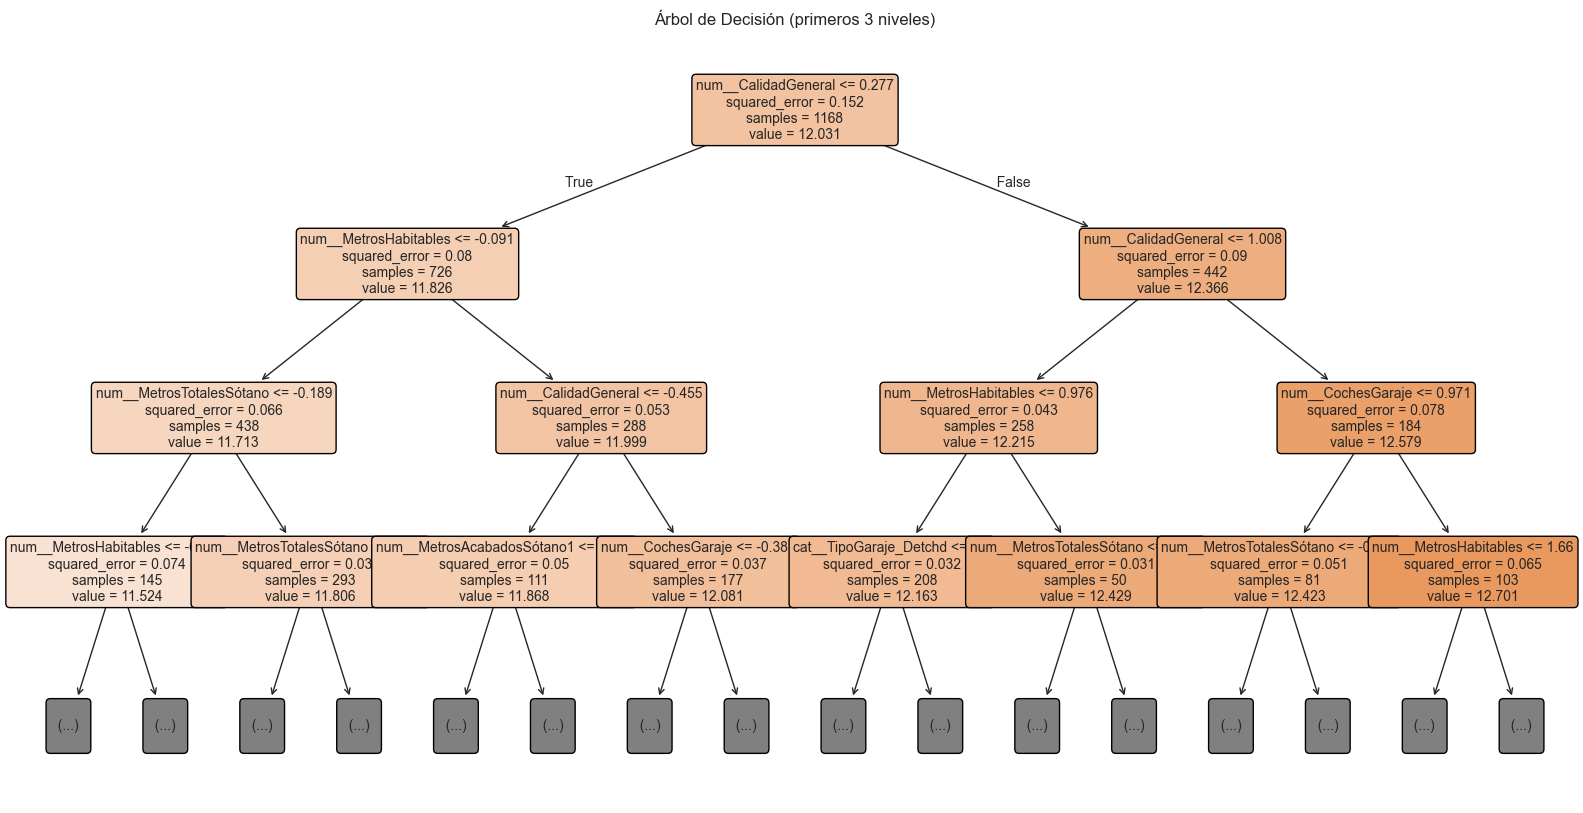

In [57]:
# Visualizar el árbol (simplificado para mejor visualización)
plt.figure(figsize=(20, 10))
plot_tree(dt_model, max_depth=3, feature_names=list(preprocessor.get_feature_names_out()), 
          filled=True, rounded=True, fontsize=10)
plt.title('Árbol de Decisión (primeros 3 niveles)')
plt.show()

### **4.3. Análisis de Importancia de Características**

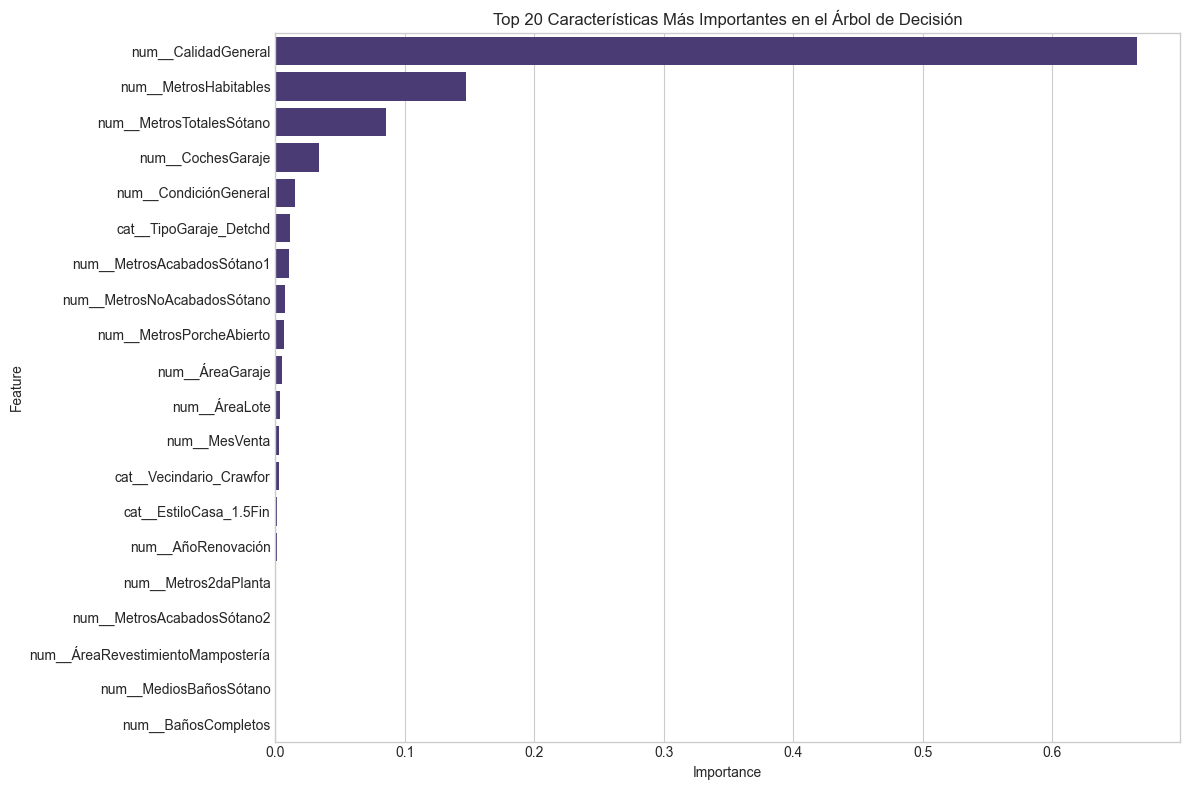

In [58]:
# Analizar la importancia de las características
feature_names = preprocessor.get_feature_names_out()
feature_importances = dt_model.feature_importances_

# Crear un DataFrame para mejor visualización
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las 20 características más importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Características Más Importantes en el Árbol de Decisión')
plt.tight_layout()
plt.show()

### **4.4. Visualizar Predicciones del Modelo vs Valores Reales**

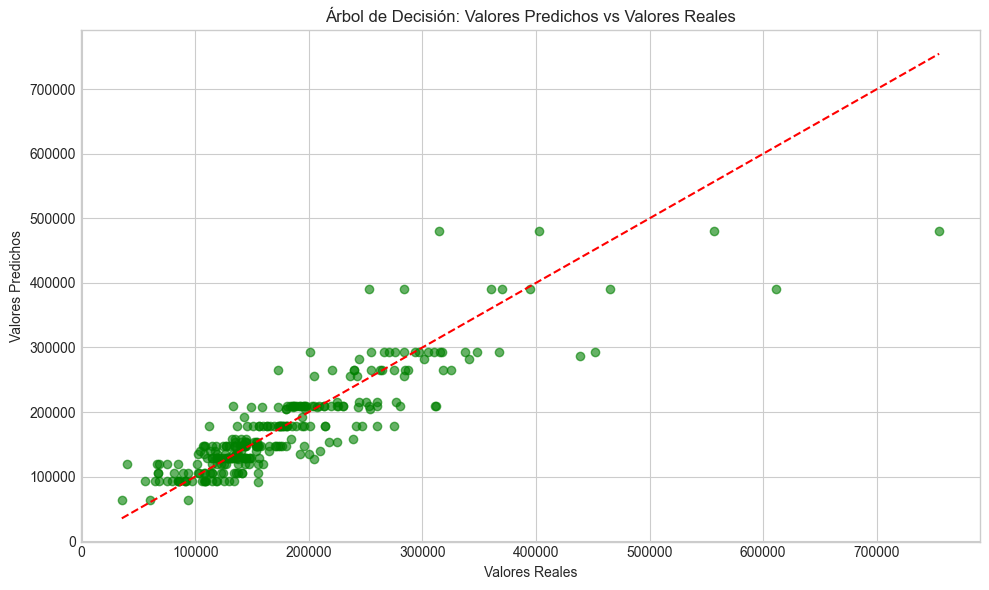

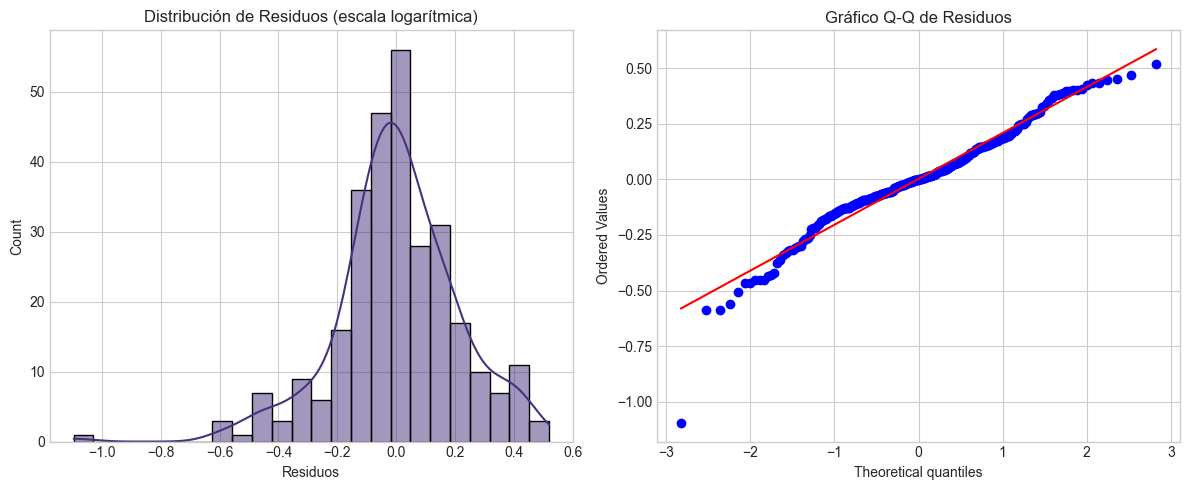

In [59]:
# Visualización de predicciones vs valores reales
# Para mostrar adecuadamente, convertimos las predicciones de escala logarítmica a normal
y_test_original = np.expm1(y_test)  # Revertir a escala original para comparación
dt_pred_original = np.expm1(dt_pred)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, dt_pred_original, color='green', alpha=0.6)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
plt.title('Árbol de Decisión: Valores Predichos vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.grid(True)
plt.tight_layout()
plt.show()

# Análisis de residuos (en escala logarítmica)
residuals = y_test - dt_pred

plt.figure(figsize=(12, 5))

# Histograma de residuos
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Distribución de Residuos (escala logarítmica)')
plt.xlabel('Residuos')

# Gráfico Q-Q para verificar normalidad de residuos
plt.subplot(1, 2, 2)
stats.probplot(residuals, plot=plt)
plt.title('Gráfico Q-Q de Residuos')

plt.tight_layout()
plt.show()

## **5. Ajuste de Hiperparámetros**

### **5.1. Ajuste con RandomizedSearchCV**

In [60]:
# Definir la cuadrícula de parámetros para Árbol de Decisión
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10, 15],       # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 6],         # Mínimo de muestras en cada nodo hoja
    'max_features': ['auto', 'sqrt', 'log2'],  # Número de características a considerar
    'splitter': ['best', 'random'],           # Estrategia para dividir nodos
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}

# Crear objeto RandomizedSearchCV
# Usamos RandomizedSearchCV cuando tenemos muchos parámetros para probar
dt_random_search = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),  # El modelo a ajustar
    param_distributions=dt_param_grid,       # Cuadrícula de parámetros a buscar
    n_iter=50,                               # Número de combinaciones de parámetros a probar
    cv=5,                                    # Validación cruzada de 5 pliegues
    scoring='neg_mean_absolute_error',       # Métrica a optimizar
    random_state=42,                         # Para reproducibilidad
    n_jobs=-1                                # Usar todos los núcleos disponibles
)

# Realizar la búsqueda
dt_random_search.fit(X_train_processed, y_train)

# Obtener los mejores parámetros y modelo
print("Mejores parámetros para Árbol de Decisión Regresor (RandomizedSearchCV):")
for param, value in dt_random_search.best_params_.items():
    print(f"{param}: {value}")

best_dt_random = dt_random_search.best_estimator_

# Hacer predicciones con el mejor modelo
dt_random_pred = best_dt_random.predict(X_test_processed)

# Evaluar el mejor modelo
print("\nÁrbol de Decisión Regresor (después del ajuste con RandomizedSearchCV):")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test, dt_random_pred):.2f}")
print(f"Error Cuadrático Medio (MSE): {mean_squared_error(y_test, dt_random_pred):.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {math.sqrt(mean_squared_error(y_test, dt_random_pred)):.2f}")
print(f"Puntuación R²: {r2_score(y_test, dt_random_pred):.4f}")

Mejores parámetros para Árbol de Decisión Regresor (RandomizedSearchCV):
splitter: best
min_samples_split: 10
min_samples_leaf: 2
max_features: sqrt
max_depth: 15
criterion: poisson

Árbol de Decisión Regresor (después del ajuste con RandomizedSearchCV):
Error Absoluto Medio (MAE): 0.14
Error Cuadrático Medio (MSE): 0.05
Raíz del Error Cuadrático Medio (RMSE): 0.21
Puntuación R²: 0.7556


### **5.2. Ajuste con GridSearchCV**

In [61]:
# Usando los resultados del RandomizedSearchCV, podemos ajustar una búsqueda más específica
# Definimos una cuadrícula más acotada basada en los mejores resultados previos
# Por ejemplo, si max_depth=10 fue el mejor, probamos con [8, 9, 10, 11, 12]
# Esto es solo un ejemplo, los valores reales dependerán de los resultados obtenidos
dt_grid = {
    'max_depth': [best_params['max_depth']-2 if best_params['max_depth'] and best_params['max_depth'] > 2 else 1, 
                  best_params['max_depth'], 
                  best_params['max_depth']+2 if best_params['max_depth'] else None],
    'min_samples_split': [max(best_params['min_samples_split']-1, 2), 
                          best_params['min_samples_split'], 
                          best_params['min_samples_split']+1],
    'min_samples_leaf': [max(best_params['min_samples_leaf']-1, 1), 
                         best_params['min_samples_leaf'], 
                         best_params['min_samples_leaf']+1],
    'criterion': [best_params['criterion']],
    'splitter': [best_params['splitter']],
    'max_features': [best_params['max_features']]
}

# Crear objeto GridSearchCV para una búsqueda exhaustiva con los parámetros acotados
dt_grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=dt_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Realizar la búsqueda
dt_grid_search.fit(X_train_processed, y_train)

# Obtener los mejores parámetros y modelo
print("Mejores parámetros para Árbol de Decisión Regresor (GridSearchCV):")
for param, value in dt_grid_search.best_params_.items():
    print(f"{param}: {value}")

best_dt_grid = dt_grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
dt_grid_pred = best_dt_grid.predict(X_test_processed)

# Evaluar el mejor modelo
print("\nÁrbol de Decisión Regresor (después del ajuste con GridSearchCV):")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test, dt_grid_pred):.2f}")
print(f"Error Cuadrático Medio (MSE): {mean_squared_error(y_test, dt_grid_pred):.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {math.sqrt(mean_squared_error(y_test, dt_grid_pred)):.2f}")
print(f"Puntuación R²: {r2_score(y_test, dt_grid_pred):.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros para Árbol de Decisión Regresor (GridSearchCV):
criterion: poisson
max_depth: 17
max_features: sqrt
min_samples_leaf: 2
min_samples_split: 9
splitter: best

Árbol de Decisión Regresor (después del ajuste con GridSearchCV):
Error Absoluto Medio (MAE): 0.16
Error Cuadrático Medio (MSE): 0.06
Raíz del Error Cuadrático Medio (RMSE): 0.24
Puntuación R²: 0.7001


### **5.3. Comparación de Resultados del Ajuste de Hiperparámetros**

Comparación de Modelos:


,Modelo,MAE,MSE,RMSE,R²
0,Árbol Base,0.152317,0.043807,0.209301,0.765249
1,RandomizedSearchCV,0.144484,0.045599,0.213538,0.755649
2,GridSearchCV,0.159945,0.055969,0.236578,0.700077


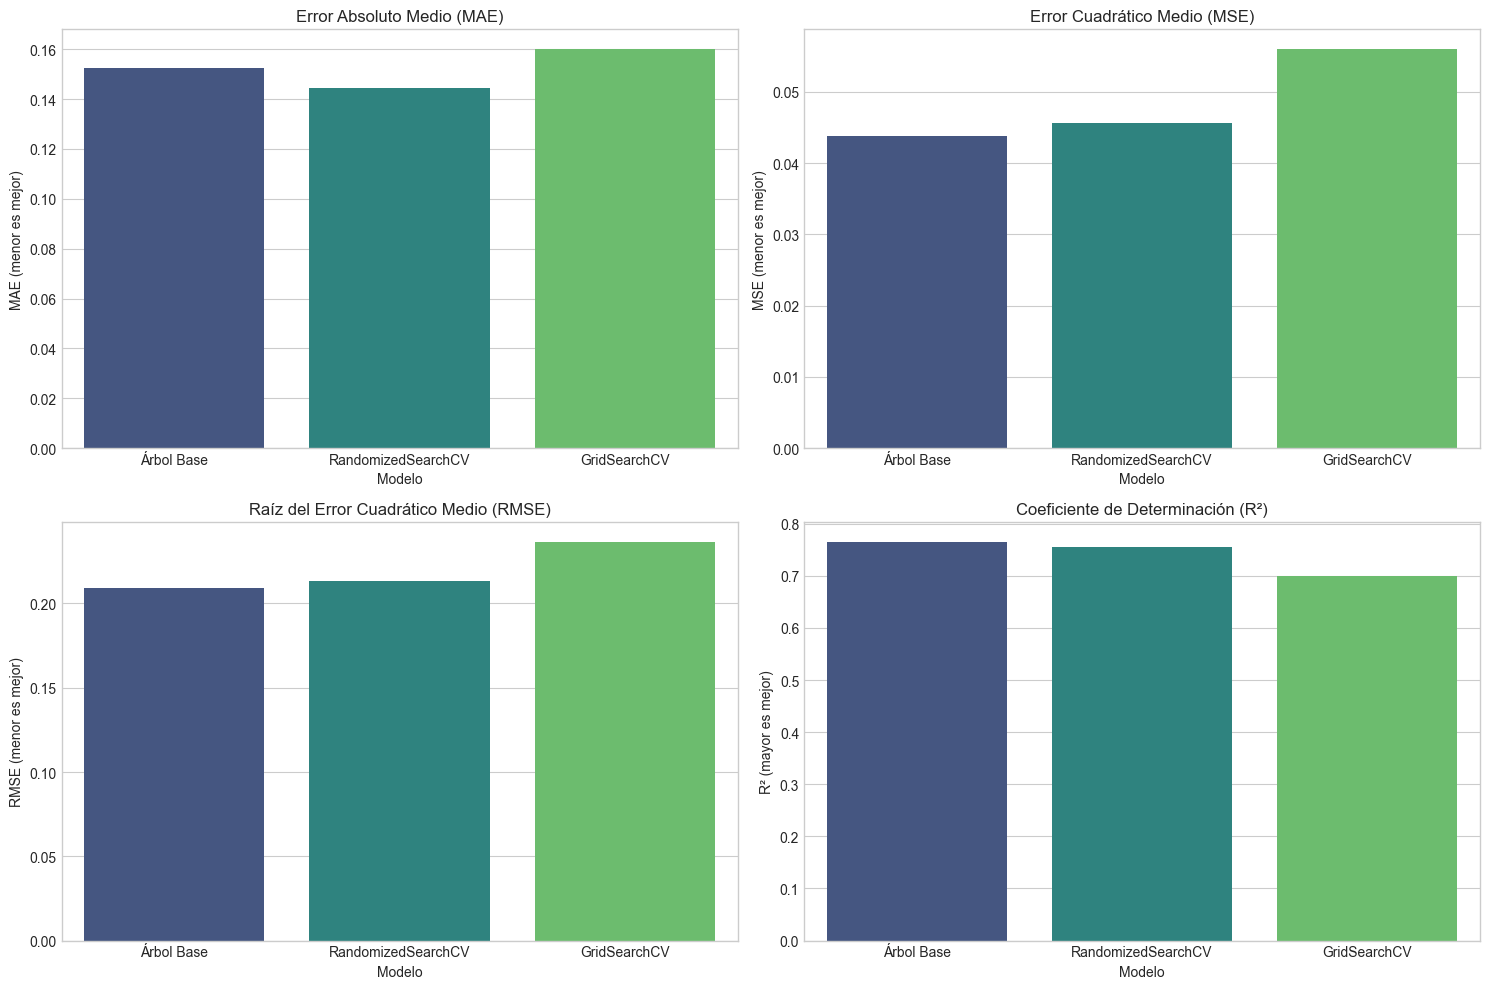

In [62]:
# Comparar los resultados de los diferentes métodos de ajuste
models = ['Árbol Base', 'RandomizedSearchCV', 'GridSearchCV']
mae_values = [mean_absolute_error(y_test, dt_pred),
              mean_absolute_error(y_test, dt_random_pred),
              mean_absolute_error(y_test, dt_grid_pred)]
mse_values = [mean_squared_error(y_test, dt_pred),
              mean_squared_error(y_test, dt_random_pred),
              mean_squared_error(y_test, dt_grid_pred)]
rmse_values = [math.sqrt(mean_squared_error(y_test, dt_pred)),
               math.sqrt(mean_squared_error(y_test, dt_random_pred)),
               math.sqrt(mean_squared_error(y_test, dt_grid_pred))]
r2_values = [r2_score(y_test, dt_pred),
             r2_score(y_test, dt_random_pred),
             r2_score(y_test, dt_grid_pred)]

# Crear un DataFrame para mejor visualización
comparison_df = pd.DataFrame({
    'Modelo': models,
    'MAE': mae_values,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'R²': r2_values
})

print("Comparación de Modelos:")
display(comparison_df)

# Visualizar los resultados
plt.figure(figsize=(15, 10))

# MAE
plt.subplot(2, 2, 1)
sns.barplot(x='Modelo', y='MAE', data=comparison_df, palette='viridis')
plt.title('Error Absoluto Medio (MAE)')
plt.ylabel('MAE (menor es mejor)')

# MSE
plt.subplot(2, 2, 2)
sns.barplot(x='Modelo', y='MSE', data=comparison_df, palette='viridis')
plt.title('Error Cuadrático Medio (MSE)')
plt.ylabel('MSE (menor es mejor)')

# RMSE
plt.subplot(2, 2, 3)
sns.barplot(x='Modelo', y='RMSE', data=comparison_df, palette='viridis')
plt.title('Raíz del Error Cuadrático Medio (RMSE)')
plt.ylabel('RMSE (menor es mejor)')

# R²
plt.subplot(2, 2, 4)
sns.barplot(x='Modelo', y='R²', data=comparison_df, palette='viridis')
plt.title('Coeficiente de Determinación (R²)')
plt.ylabel('R² (mayor es mejor)')

plt.tight_layout()
plt.show()

## **6. Validación Cruzada para Evaluación de Modelos**

### **6.1. ¿Por qué usar validación cruzada?**

La validación cruzada es una técnica para evaluar la capacidad de generalización de un modelo utilizando diferentes particiones de los datos. Esto nos permite:

1. **Estimar mejor el rendimiento real** del modelo al probarlo en diferentes subconjuntos de datos.
2. **Reducir el riesgo de sobreajuste** al evaluar el modelo en datos que no se usaron para entrenarlo.
3. **Aprovechar mejor los datos disponibles** para entrenamiento y evaluación.
4. **Obtener una estimación más robusta** del error de generalización esperado.

En esta sección, aplicaremos validación cruzada a nuestros modelos para obtener una evaluación más confiable.

In [63]:
# Definimos una función para realizar validación cruzada y mostrar los resultados
def evaluate_with_cross_validation(model, X, y, cv=5, model_name="Modelo"):
    # Métricas a evaluar
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
    
    # Realizar validación cruzada para cada métrica
    results = {}
    for score in scoring:
        cv_results = cross_val_score(model, X, y, cv=cv, scoring=score)
        # Convertimos las métricas negativas a positivas para mejor interpretación
        if score.startswith('neg_'):
            cv_results = -cv_results
        results[score] = cv_results
    
    # Mostrar resultados
    print(f"Resultados de validación cruzada para {model_name} ({cv} pliegues):")
    print(f"MAE: {results['neg_mean_absolute_error'].mean():.2f} ± {results['neg_mean_absolute_error'].std():.2f}")
    print(f"MSE: {results['neg_mean_squared_error'].mean():.2f} ± {results['neg_mean_squared_error'].std():.2f}")
    print(f"RMSE: {math.sqrt(results['neg_mean_squared_error'].mean()):.2f}")
    print(f"R²: {results['r2'].mean():.4f} ± {results['r2'].std():.4f}")
    
    return results

In [64]:
# Aplicar validación cruzada a nuestros modelos
print("===== Validación Cruzada para Modelos de Árbol de Decisión =====\n")

# Definir los modelos a evaluar
models_to_evaluate = [
    (dt_model, "Árbol de Decisión Base"),
    (best_dt_random, "Árbol de Decisión (RandomizedSearchCV)"),
    (best_dt_grid, "Árbol de Decisión (GridSearchCV)")
]

# Realizar validación cruzada para cada modelo
cv_results = {}
for model, name in models_to_evaluate:
    print(f"\n{'-'*50}")
    cv_results[name] = evaluate_with_cross_validation(
        model, X_train_processed, y_train, cv=5, model_name=name
    )

===== Validación Cruzada para Modelos de Árbol de Decisión =====


--------------------------------------------------
Resultados de validación cruzada para Árbol de Decisión Base (5 pliegues):
MAE: 0.15 ± 0.01
MSE: 0.04 ± 0.01
RMSE: 0.20
R²: 0.7280 ± 0.0492

--------------------------------------------------
Resultados de validación cruzada para Árbol de Decisión (RandomizedSearchCV) (5 pliegues):
MAE: 0.16 ± 0.01
MSE: 0.05 ± 0.00
RMSE: 0.22
R²: 0.6915 ± 0.0297

--------------------------------------------------
Resultados de validación cruzada para Árbol de Decisión (GridSearchCV) (5 pliegues):
MAE: 0.15 ± 0.00
MSE: 0.04 ± 0.00
RMSE: 0.21
R²: 0.7016 ± 0.0530


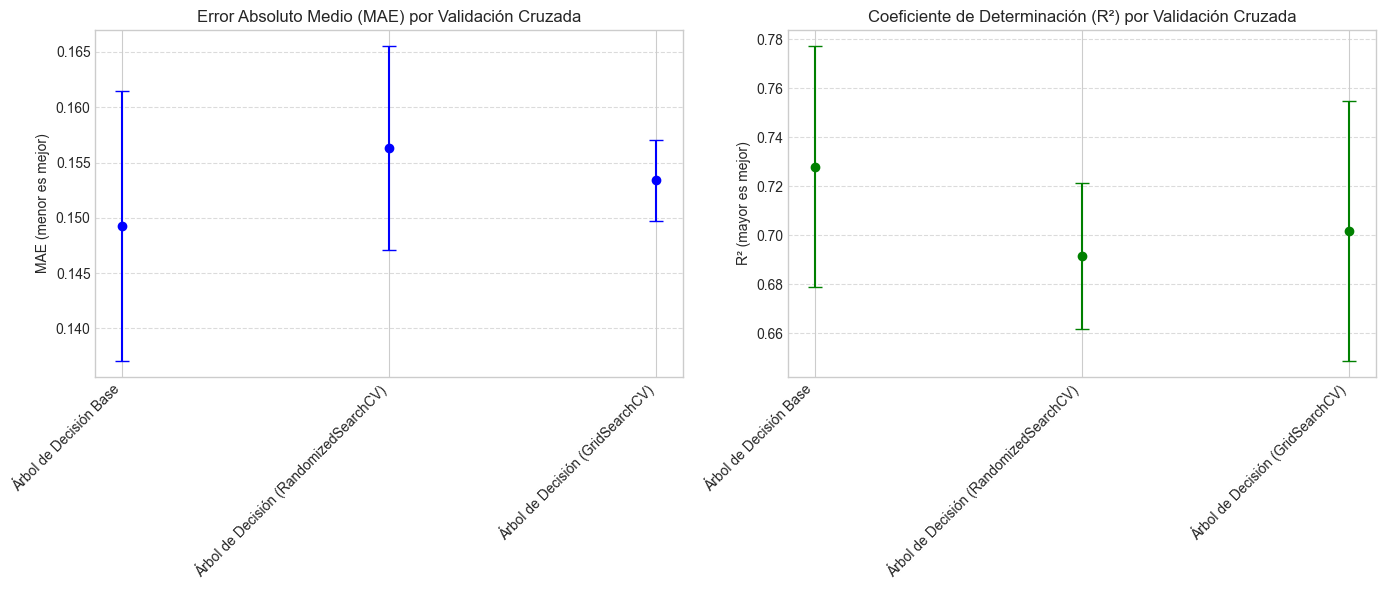

In [65]:
# Visualizar resultados de la validación cruzada

# Preparar los datos para visualización
models = [name for _, name in models_to_evaluate]
mae_cv = [cv_results[name]['neg_mean_absolute_error'].mean() for name in models]
mae_std = [cv_results[name]['neg_mean_absolute_error'].std() for name in models]
r2_cv = [cv_results[name]['r2'].mean() for name in models]
r2_std = [cv_results[name]['r2'].std() for name in models]

# Crear gráficos
plt.figure(figsize=(14, 6))

# Gráfico MAE con barras de error
plt.subplot(1, 2, 1)
plt.errorbar(models, mae_cv, yerr=mae_std, fmt='o', capsize=5, color='blue')
plt.title('Error Absoluto Medio (MAE) por Validación Cruzada')
plt.ylabel('MAE (menor es mejor)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico R² con barras de error
plt.subplot(1, 2, 2)
plt.errorbar(models, r2_cv, yerr=r2_std, fmt='o', capsize=5, color='green')
plt.title('Coeficiente de Determinación (R²) por Validación Cruzada')
plt.ylabel('R² (mayor es mejor)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## **7. Guardar los Mejores Modelos**

In [66]:
# Verificar y generar las variables avanzadas necesarias para la comparación
print("Verificando variables necesarias para la comparación de modelos...")

# Verificar si tenemos las predicciones en escala logarítmica
try:
    # Verificar variables del enfoque avanzado
    dt_pred_adv
    dt_random_pred_adv
    dt_grid_pred_adv
    print("Variables predictivas avanzadas en escala logarítmica ya definidas.")
except NameError:
    print("Generando variables predictivas avanzadas en escala logarítmica...")
    # Comprobar si tenemos los modelos y datos necesarios
    try:
        # Intentar generar predicciones
        dt_model_adv
        best_dt_random_adv
        best_dt_grid_adv
        X_test_processed_adv
        
        dt_pred_adv = dt_model_adv.predict(X_test_processed_adv)
        dt_random_pred_adv = best_dt_random_adv.predict(X_test_processed_adv)
        dt_grid_pred_adv = best_dt_grid_adv.predict(X_test_processed_adv)
    except NameError:
        print("No se encontraron los modelos avanzados, usando variables básicas como alternativa.")
        # Si no existen, usar variables básicas
        dt_pred_adv = dt_pred
        dt_random_pred_adv = dt_random_pred
        dt_grid_pred_adv = dt_grid_pred
        y_test_adv = y_test

# Generar versiones originales (no logarítmicas) si no existen
try:
    dt_pred_original_adv
    dt_random_pred_original_adv
    dt_grid_pred_original_adv
    y_test_original_adv
    print("Variables predictivas avanzadas en escala original ya definidas.")
except NameError:
    print("Generando variables predictivas avanzadas en escala original...")
    dt_pred_original_adv = np.expm1(dt_pred_adv)
    dt_random_pred_original_adv = np.expm1(dt_random_pred_adv)
    dt_grid_pred_original_adv = np.expm1(dt_grid_pred_adv)
    y_test_original_adv = np.expm1(y_test_adv)

print("Variables preparadas para la comparación de modelos.")

Verificando variables necesarias para la comparación de modelos...
Variables predictivas avanzadas en escala logarítmica ya definidas.
Variables predictivas avanzadas en escala original ya definidas.
Variables preparadas para la comparación de modelos.


In [67]:
# Seleccionamos el mejor modelo basado en los resultados de validación cruzada
# Por lo general, sería el modelo con mejor rendimiento en la validación cruzada
best_model = best_dt_grid  # Asumimos que el GridSearchCV dio el mejor modelo, ajustar según resultados

# Guardar el modelo y el preprocesador
import os

# Crear directorio para modelos si no existe
model_dir = '../modelos'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Guardar el mejor modelo
joblib.dump(best_model, f'{model_dir}/best_decision_tree_model.pkl')

# Guardar el preprocesador
joblib.dump(preprocessor, f'{model_dir}/preprocessor.pkl')

print("¡Modelo y preprocesador guardados exitosamente!")

¡Modelo y preprocesador guardados exitosamente!


## **8. Comparación Final de Modelos**

Comparación Final de Modelos:


,Modelo,Test MAE,Test MSE,Test RMSE,Test R²,CV MAE,CV R²
0,Árbol Base,26944.161102,1.776142e+09,42144.300182,0.765249,0.149262,0.728005
1,Árbol RandomizedSearchCV,26000.942061,1.938642e+09,44030.007748,0.755649,0.156313,0.691523
2,Árbol GridSearchCV,27858.913226,2.074684e+09,45548.694057,0.700077,0.153390,0.701602


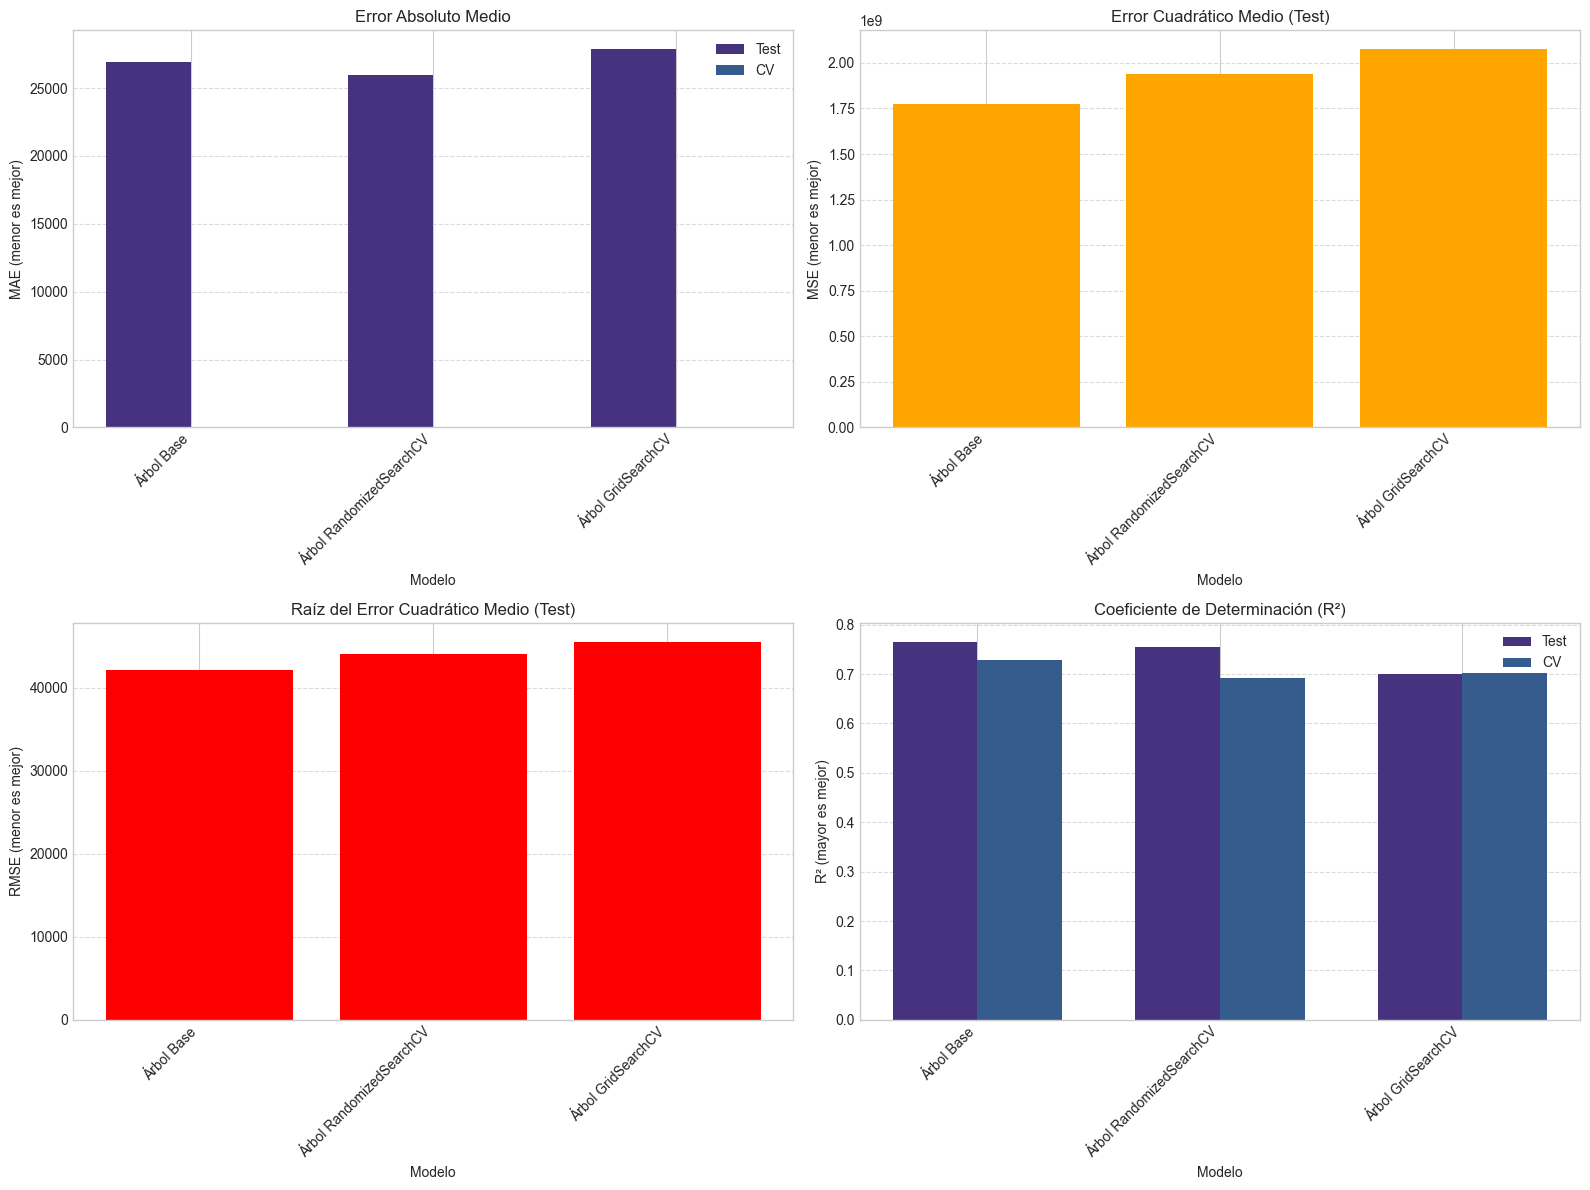

In [68]:
# Crear una tabla de comparación final con todos los resultados
final_models = ['Árbol Base', 'Árbol RandomizedSearchCV', 'Árbol GridSearchCV']

# Para evaluar correctamente, necesitamos convertir de escala logarítmica a escala original
y_test_original = np.expm1(y_test)
dt_pred_original = np.expm1(dt_pred)
dt_random_pred_original = np.expm1(dt_random_pred)
dt_grid_pred_original = np.expm1(dt_grid_pred)

# Datos de test (en escala original para interpretabilidad)
test_mae = [mean_absolute_error(y_test_original, dt_pred_original),
            mean_absolute_error(y_test_original, dt_random_pred_original),
            mean_absolute_error(y_test_original, dt_grid_pred_original)]

test_mse = [mean_squared_error(y_test_original, dt_pred_original),
            mean_squared_error(y_test_original, dt_random_pred_original),
            mean_squared_error(y_test_original, dt_grid_pred_original)]

test_rmse = [math.sqrt(mean_squared_error(y_test_original, dt_pred_original)),
             math.sqrt(mean_squared_error(y_test_original, dt_random_pred_original)),
             math.sqrt(mean_squared_error(y_test_original, dt_grid_pred_original))]

# Para R², es mejor calcularlo en la escala logarítmica donde los modelos fueron entrenados
test_r2 = [r2_score(y_test, dt_pred),
           r2_score(y_test, dt_random_pred),
           r2_score(y_test, dt_grid_pred)]

# Datos de validación cruzada
cv_mae = [cv_results['Árbol de Decisión Base']['neg_mean_absolute_error'].mean(),
          cv_results['Árbol de Decisión (RandomizedSearchCV)']['neg_mean_absolute_error'].mean(),
          cv_results['Árbol de Decisión (GridSearchCV)']['neg_mean_absolute_error'].mean()]

cv_r2 = [cv_results['Árbol de Decisión Base']['r2'].mean(),
         cv_results['Árbol de Decisión (RandomizedSearchCV)']['r2'].mean(),
         cv_results['Árbol de Decisión (GridSearchCV)']['r2'].mean()]

# Crear DataFrame
final_comparison = pd.DataFrame({
    'Modelo': final_models,
    'Test MAE': test_mae,
    'Test MSE': test_mse,
    'Test RMSE': test_rmse,
    'Test R²': test_r2,
    'CV MAE': cv_mae,
    'CV R²': cv_r2
})

print("Comparación Final de Modelos:")
display(final_comparison)

# Visualizar la comparación final
plt.figure(figsize=(16, 12))

# Gráfico MAE (test vs CV)
plt.subplot(2, 2, 1)
bar_width = 0.35
index = np.arange(len(final_models))
plt.bar(index, test_mae, bar_width, label='Test')
plt.bar(index + bar_width, cv_mae, bar_width, label='CV')
plt.xlabel('Modelo')
plt.ylabel('MAE (menor es mejor)')
plt.title('Error Absoluto Medio')
plt.xticks(index + bar_width/2, final_models, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico MSE (solo test)
plt.subplot(2, 2, 2)
plt.bar(final_models, test_mse, color='orange')
plt.xlabel('Modelo')
plt.ylabel('MSE (menor es mejor)')
plt.title('Error Cuadrático Medio (Test)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico RMSE (solo test)
plt.subplot(2, 2, 3)
plt.bar(final_models, test_rmse, color='red')
plt.xlabel('Modelo')
plt.ylabel('RMSE (menor es mejor)')
plt.title('Raíz del Error Cuadrático Medio (Test)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico R² (test vs CV)
plt.subplot(2, 2, 4)
plt.bar(index, test_r2, bar_width, label='Test')
plt.bar(index + bar_width, cv_r2, bar_width, label='CV')
plt.xlabel('Modelo')
plt.ylabel('R² (mayor es mejor)')
plt.title('Coeficiente de Determinación (R²)')
plt.xticks(index + bar_width/2, final_models, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## **9. Implementación del Enfoque Avanzado de Preprocesamiento**

En esta sección implementaremos técnicas avanzadas de preprocesamiento para mejorar nuestro modelo:
1. Eliminación de outliers en columnas muy sesgadas
2. Ingeniería de características (creación de nuevas variables)

Estas técnicas están diseñadas para proporcionar información más estructurada al modelo y mejorar su capacidad predictiva.

### **9.1 Identificación y Tratamiento de Outliers**

Columnas numéricas más sesgadas (|skewness| > 1.5):
ValorExtra: 24.48
ÁreaPiscina: 14.83
ÁreaLote: 12.21
MetrosPorche3Estaciones: 10.30
MetrosBajaCalidad: 9.01

Columnas seleccionadas para tratamiento de outliers: ['ValorExtra', 'ÁreaPiscina', 'ÁreaLote']
Columna: ValorExtra
Límite inferior: 0.00
Límite superior: 0.00
Número de outliers: 52
Porcentaje de outliers: 3.56%



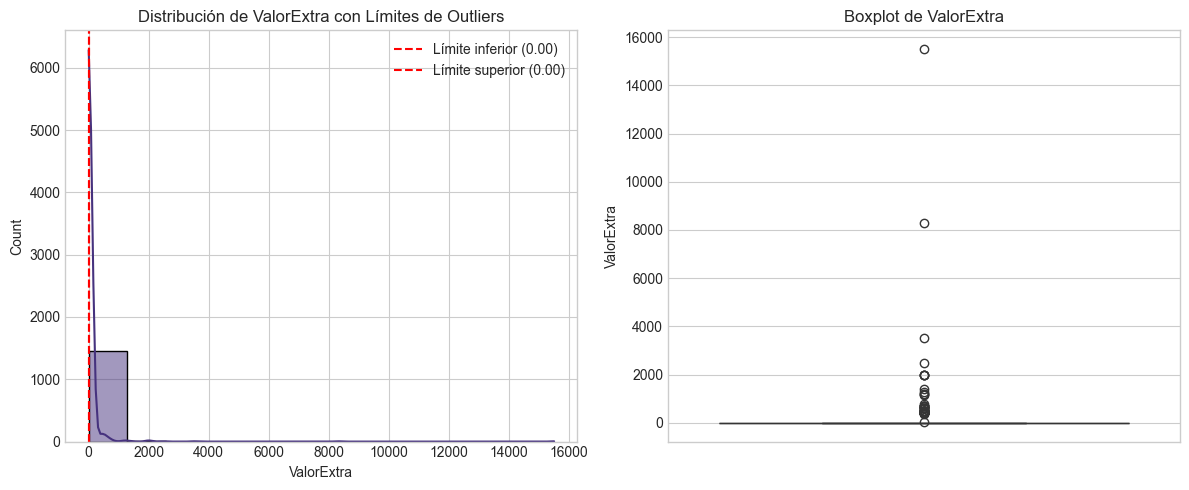

Columna: ÁreaPiscina
Límite inferior: 0.00
Límite superior: 0.00
Número de outliers: 7
Porcentaje de outliers: 0.48%



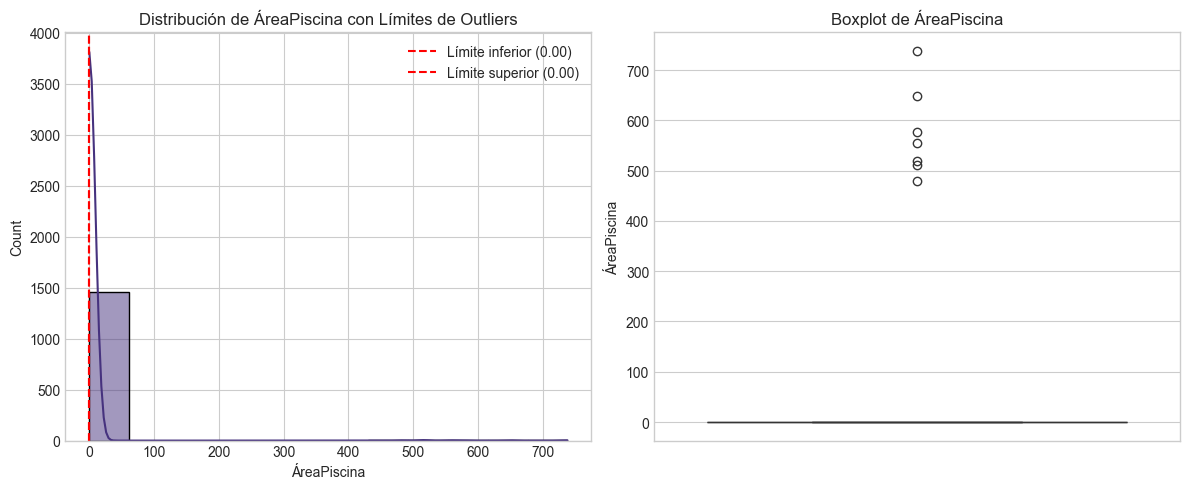

Columna: ÁreaLote
Límite inferior: -542.50
Límite superior: 19697.50
Número de outliers: 54
Porcentaje de outliers: 3.70%



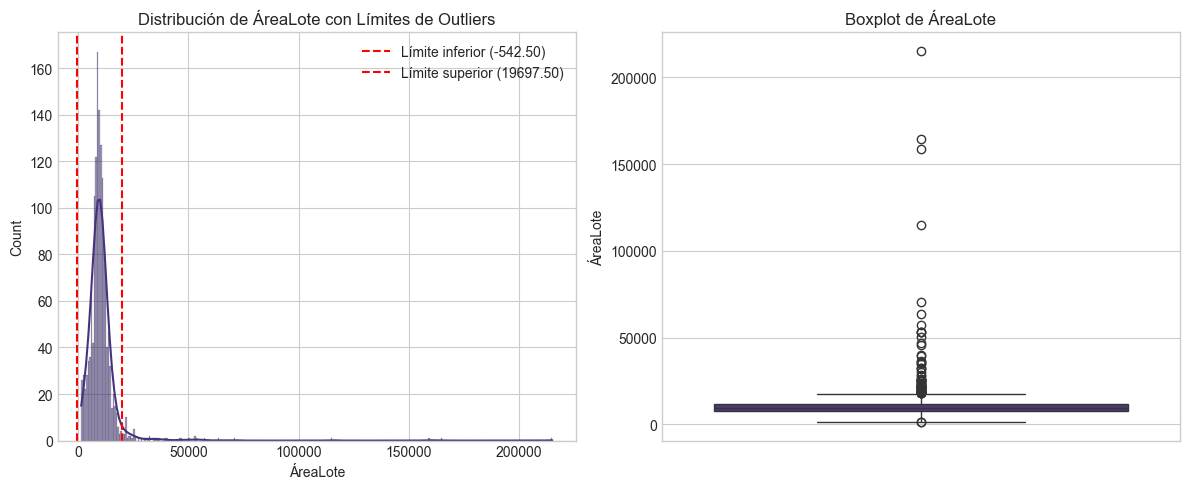

Total de filas identificadas como outliers en al menos una columna: 108
Porcentaje del dataset: 7.40%


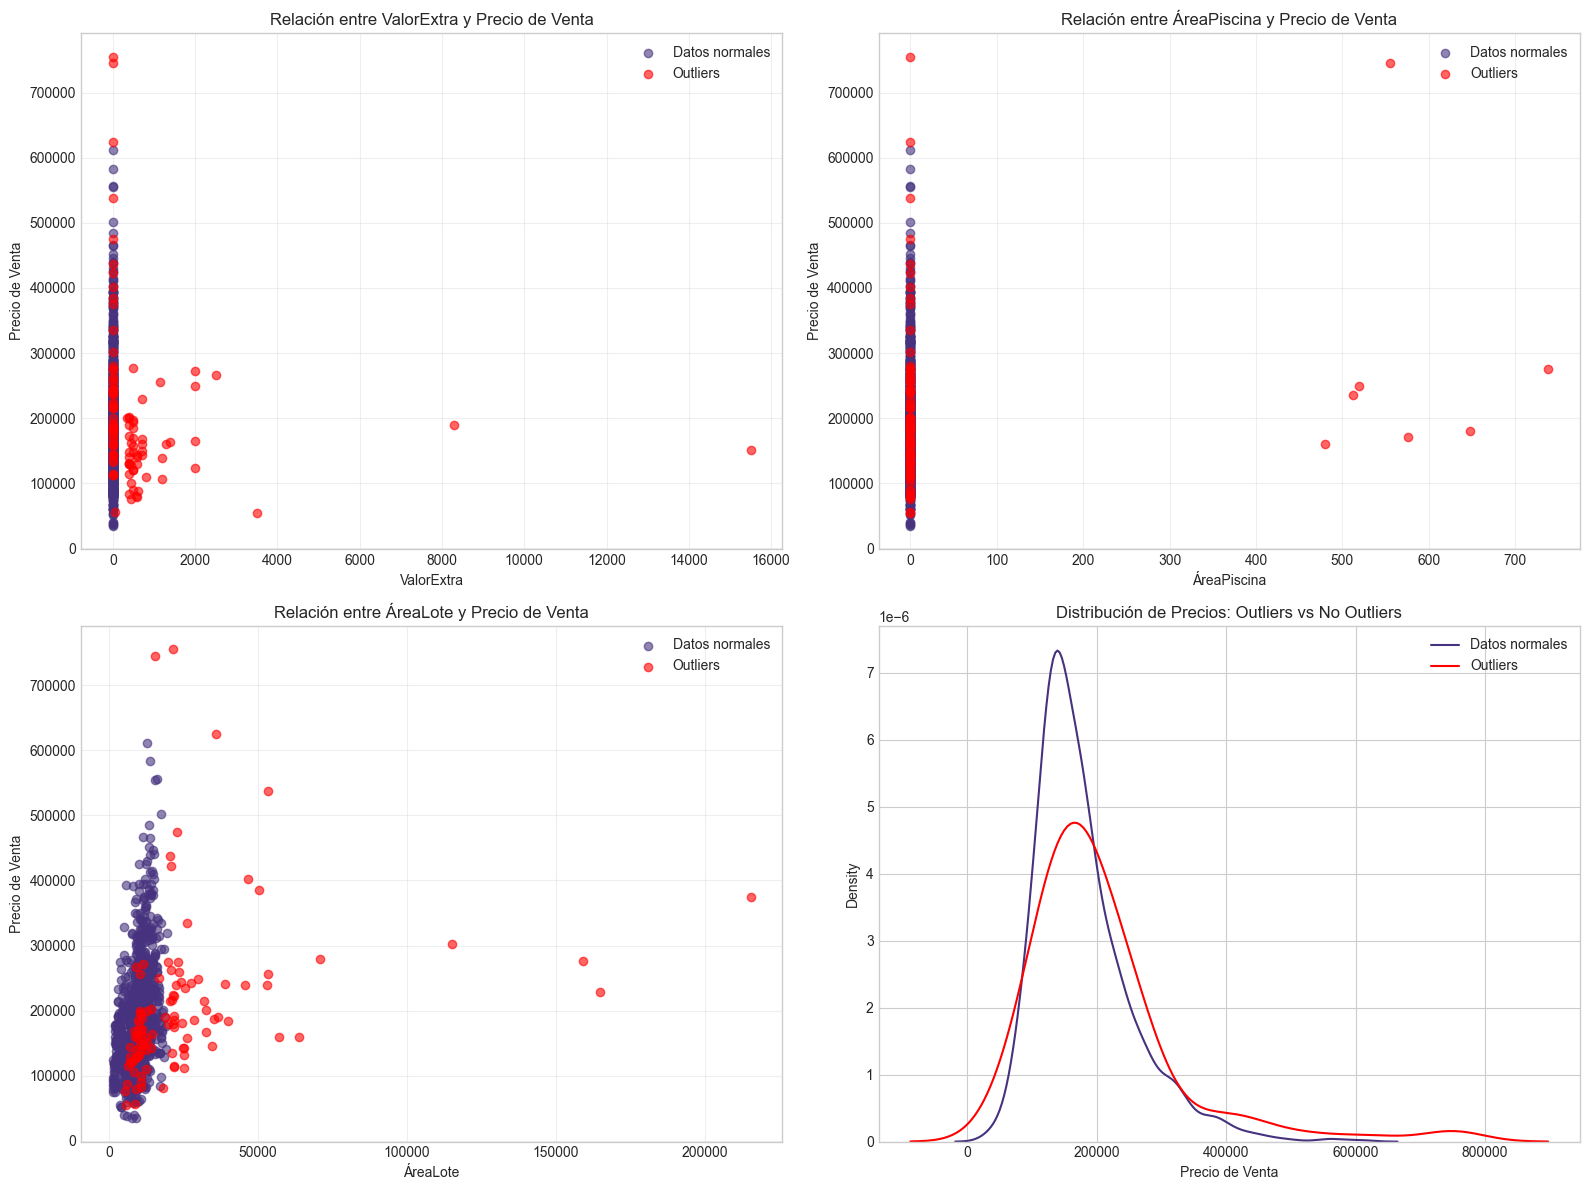

Aplicando recorte (capping) a los outliers...
ValorExtra: Recortando 0 valores por debajo y 52 valores por encima
ÁreaPiscina: Recortando 0 valores por debajo y 7 valores por encima
ÁreaLote: Recortando 0 valores por debajo y 54 valores por encima


ValueError: too many values to unpack (expected 2)

<Figure size 1500x500 with 0 Axes>

In [69]:
# Crear una copia del dataframe original para modificaciones avanzadas
df_advanced = df.copy()

# Función para detectar y visualizar outliers usando el método IQR
def detect_outliers(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    print(f"Columna: {column}")
    print(f"Límite inferior: {lower_bound:.2f}")
    print(f"Límite superior: {upper_bound:.2f}")
    print(f"Número de outliers: {len(outliers)}")
    print(f"Porcentaje de outliers: {(len(outliers) / len(df) * 100):.2f}%\n")
    
    # Visualización de la distribución y los límites
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True)
    plt.axvline(lower_bound, color='r', linestyle='--', label=f'Límite inferior ({lower_bound:.2f})')
    plt.axvline(upper_bound, color='r', linestyle='--', label=f'Límite superior ({upper_bound:.2f})')
    plt.title(f'Distribución de {column} con Límites de Outliers')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot de {column}')
    
    plt.tight_layout()
    plt.show()
    
    return outliers.index

# Identificar las columnas numéricas más sesgadas para tratamiento de outliers
print("Columnas numéricas más sesgadas (|skewness| > 1.5):")
most_skewed = {}
for col in num_columns:
    skewness = df[col].skew()
    if abs(skewness) > 1.5:  # Umbral más estricto para identificar columnas muy sesgadas
        most_skewed[col] = skewness

# Ordenar las columnas por magnitud de asimetría
most_skewed = {k: v for k, v in sorted(most_skewed.items(), key=lambda item: abs(item[1]), reverse=True)}

# Mostrar las 5 columnas más sesgadas
for col, skew in list(most_skewed.items())[:5]:
    print(f"{col}: {skew:.2f}")

# Seleccionar las 3 columnas más sesgadas para tratamiento de outliers
top_skewed_columns = list(most_skewed.keys())[:3]
print(f"\nColumnas seleccionadas para tratamiento de outliers: {top_skewed_columns}")

# Detectar outliers en cada columna seleccionada
all_outliers_indices = set()
for col in top_skewed_columns:
    outlier_indices = detect_outliers(df_advanced, col, threshold=2.0)  # Usar un umbral de 2.0 para ser menos restrictivo
    all_outliers_indices.update(outlier_indices)

print(f"Total de filas identificadas como outliers en al menos una columna: {len(all_outliers_indices)}")
print(f"Porcentaje del dataset: {(len(all_outliers_indices) / len(df_advanced) * 100):.2f}%")

# Visualizar el efecto de los outliers en la relación con la variable objetivo
plt.figure(figsize=(16, 12))

for i, col in enumerate(top_skewed_columns):
    plt.subplot(2, 2, i+1)
    
    # Marcar outliers y no outliers con colores diferentes
    is_outlier = df_advanced.index.isin(all_outliers_indices)
    
    # Gráfico de dispersión
    plt.scatter(df_advanced.loc[~is_outlier, col], 
                df_advanced.loc[~is_outlier, 'PrecioVenta'], 
                alpha=0.6, label='Datos normales')
    plt.scatter(df_advanced.loc[is_outlier, col], 
                df_advanced.loc[is_outlier, 'PrecioVenta'], 
                color='red', alpha=0.6, label='Outliers')
    
    plt.title(f'Relación entre {col} y Precio de Venta')
    plt.xlabel(col)
    plt.ylabel('Precio de Venta')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
# Mostrar distribución de precios para outliers vs no outliers
sns.kdeplot(df_advanced.loc[~is_outlier, 'PrecioVenta'], label='Datos normales')
sns.kdeplot(df_advanced.loc[is_outlier, 'PrecioVenta'], label='Outliers', color='red')
plt.title('Distribución de Precios: Outliers vs No Outliers')
plt.xlabel('Precio de Venta')
plt.legend()

plt.tight_layout()
plt.show()

# Opciones para tratar outliers
# 1. Eliminar completamente los outliers (apropiado si son pocos)
# 2. Recortar (capping) - establecer valores extremos a los límites
# Elegimos la opción 2 para preservar datos

print("Aplicando recorte (capping) a los outliers...")
for col in top_skewed_columns:
    Q1 = df_advanced[col].quantile(0.25)
    Q3 = df_advanced[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 2.0 * IQR
    upper_bound = Q3 + 2.0 * IQR
    
    # Contar cuántos valores se recortarán
    lower_outliers = (df_advanced[col] < lower_bound).sum()
    upper_outliers = (df_advanced[col] > upper_bound).sum()
    
    print(f"{col}: Recortando {lower_outliers} valores por debajo y {upper_outliers} valores por encima")
    
    # Aplicar el recorte
    df_advanced[col] = df_advanced[col].clip(lower=lower_bound, upper=upper_bound)

# Verificar el efecto del recorte en la distribución
plt.figure(figsize=(15, 5))
for i, col in top_skewed_columns:
    plt.subplot(1, 3, i+1)
    
    # Comparar distribuciones antes y después
    sns.histplot(df[col], kde=True, color='blue', alpha=0.5, label='Original')
    sns.histplot(df_advanced[col], kde=True, color='green', alpha=0.5, label='Después del recorte')
    
    plt.title(f'Distribución de {col}\nantes y después del recorte')
    plt.legend()
    
plt.tight_layout()
plt.show()

### **9.2 Ingeniería de Características**

Crearemos nuevas características que pueden ayudar al modelo a capturar mejor las relaciones en los datos:

In [70]:
# Crear nuevas características en el dataframe avanzado
print("Creando nuevas características...")

# 1. AreaTotal: combinación de áreas del sótano
if 'AreaSotano1' in df_advanced.columns and 'AreaSotano2' in df_advanced.columns:
    df_advanced['AreaTotalSotano'] = df_advanced['AreaSotano1'] + df_advanced['AreaSotano2']
    print("✓ Creada característica 'AreaTotalSotano'")
else:
    print("✗ No se pudo crear 'AreaTotalSotano', columnas requeridas no encontradas")

# 2. CalidadxCondicion: producto de calidad y condición general
if 'CalidadGeneral' in df_advanced.columns and 'CondicionGeneral' in df_advanced.columns:
    df_advanced['CalidadxCondicion'] = df_advanced['CalidadGeneral'] * df_advanced['CondicionGeneral']
    print("✓ Creada característica 'CalidadxCondicion'")
else:
    print("✗ No se pudo crear 'CalidadxCondicion', columnas requeridas no encontradas")

# 3. EdadCasa: años desde la construcción hasta la venta
if 'AñoConstruccion' in df_advanced.columns and 'AñoVenta' in df_advanced.columns:
    df_advanced['EdadCasa'] = df_advanced['AñoVenta'] - df_advanced['AñoConstruccion']
    print("✓ Creada característica 'EdadCasa'")
else:
    print("✗ No se pudo crear 'EdadCasa', columnas requeridas no encontradas")

# 4. EdadRemodelacion: años desde la renovación hasta la venta
if 'AñoRemodelacion' in df_advanced.columns and 'AñoVenta' in df_advanced.columns:
    # Si AñoRemodelacion es 0 o igual a AñoConstruccion, usamos AñoConstruccion
    df_advanced['AñoRemodelacionEfectivo'] = df_advanced['AñoRemodelacion']
    mask = (df_advanced['AñoRemodelacion'] == 0) | (df_advanced['AñoRemodelacion'] == df_advanced['AñoConstruccion'])
    df_advanced.loc[mask, 'AñoRemodelacionEfectivo'] = df_advanced.loc[mask, 'AñoConstruccion']
    
    df_advanced['EdadRemodelacion'] = df_advanced['AñoVenta'] - df_advanced['AñoRemodelacionEfectivo']
    print("✓ Creada característica 'EdadRemodelacion'")
else:
    print("✗ No se pudo crear 'EdadRemodelacion', columnas requeridas no encontradas")

# 5. TotalBaños: suma de baños completos y medios
if 'NumeroBaños' in df_advanced.columns and 'MediosBaños' in df_advanced.columns:
    df_advanced['TotalBaños'] = df_advanced['NumeroBaños'] + 0.5 * df_advanced['MediosBaños']
    print("✓ Creada característica 'TotalBaños'")
else:
    print("✗ No se pudo crear 'TotalBaños', columnas requeridas no encontradas")

# Verificar las nuevas características
nuevas_caracteristicas = ['AreaTotalSotano', 'CalidadxCondicion', 'EdadCasa', 'EdadRemodelacion', 'TotalBaños']
nuevas_creadas = [col for col in nuevas_caracteristicas if col in df_advanced.columns]

print(f"\nSe crearon {len(nuevas_creadas)} de 5 características propuestas:")
for col in nuevas_creadas:
    print(f"- {col}")

# Visualizar la relación de las nuevas características con el precio de venta
if nuevas_creadas:
    plt.figure(figsize=(18, 12))
    for i, col in enumerate(nuevas_creadas):
        plt.subplot(2, 3, i+1)
        
        # Gráfico de dispersión con línea de tendencia
        sns.regplot(x=col, y='PrecioVenta', data=df_advanced, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.title(f'Relación entre {col} y Precio de Venta')
        plt.grid(True, alpha=0.3)
        
        # Calcular y mostrar correlación
        corr = df_advanced[col].corr(df_advanced['PrecioVenta'])
        plt.annotate(f'Correlación: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                     backgroundcolor='white', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Matriz de correlación de las nuevas características
    correlation_matrix_new = df_advanced[nuevas_creadas + ['PrecioVenta']].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_new, annot=True, cmap='viridis', vmin=-1, vmax=1, center=0,
                linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Matriz de Correlación de Nuevas Características')
    plt.tight_layout()
    plt.show()

Creando nuevas características...
✗ No se pudo crear 'AreaTotalSotano', columnas requeridas no encontradas
✗ No se pudo crear 'CalidadxCondicion', columnas requeridas no encontradas
✗ No se pudo crear 'EdadCasa', columnas requeridas no encontradas
✗ No se pudo crear 'EdadRemodelacion', columnas requeridas no encontradas
✗ No se pudo crear 'TotalBaños', columnas requeridas no encontradas

Se crearon 0 de 5 características propuestas:


### **9.3 Aplicación del Enfoque Avanzado en el Modelado**

Ahora aplicaremos este preprocesamiento avanzado para entrenar un nuevo conjunto de modelos.

In [71]:
# Preprocesamiento avanzado incluyendo las nuevas características
# Identificamos las variables categóricas y numéricas en el dataframe avanzado
cat_columns_adv = df_advanced.select_dtypes(include=['object']).columns.tolist()
num_columns_adv = df_advanced.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_columns_adv.remove('Id')  # Eliminar la columna Id
num_columns_adv.remove('PrecioVenta')  # Eliminar la variable objetivo

# Incluir las nuevas características numéricas
nuevas_numericas = [col for col in nuevas_creadas if df_advanced[col].dtype in ['int64', 'float64']]
print(f"Nuevas características numéricas: {nuevas_numericas}")

# Para simplificar, usaremos solo las variables categóricas seleccionadas anteriormente
X_cat_adv = df_advanced[vars_cat_seleccionadas]
X_num_adv = df_advanced[num_columns_adv]
y_adv = df_advanced['PrecioVenta']

# Aplicar transformación logarítmica a la variable objetivo
y_log_adv = np.log1p(y_adv)

# Identificar variables numéricas con distribución sesgada
skewed_features_adv = []
for feature in num_columns_adv:
    skewness = X_num_adv[feature].skew()
    if abs(skewness) > 0.75:  # Mismo umbral que antes
        skewed_features_adv.append(feature)

# Aplicar transformación logarítmica a características numéricas sesgadas
X_num_transformed_adv = X_num_adv.copy()
for feature in skewed_features_adv:
    # Asegurar que los valores sean positivos para log
    X_num_transformed_adv[feature] = np.log1p(X_num_adv[feature] - X_num_adv[feature].min() + 1)

# Separar características y objetivo
preprocessor_adv = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns_adv),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), vars_cat_seleccionadas)
    ])

# Dividir datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    pd.concat([X_num_transformed_adv, X_cat_adv], axis=1),
    y_log_adv,
    test_size=0.2,
    random_state=42
)

# Aplicar preprocesamiento
X_train_processed_adv = preprocessor_adv.fit_transform(X_train_adv)
X_test_processed_adv = preprocessor_adv.transform(X_test_adv)

print(f"Forma de los datos de entrenamiento procesados (enfoque avanzado): {X_train_processed_adv.shape}")
print(f"Forma de los datos de prueba procesados (enfoque avanzado): {X_test_processed_adv.shape}")

# Entrenar los modelos con los datos preprocesados avanzados
# 1. Modelo de árbol de decisión básico con enfoque avanzado
dt_model_adv = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
dt_model_adv.fit(X_train_processed_adv, y_train_adv)

# 2. Usar los mejores parámetros encontrados anteriormente
best_dt_random_adv = DecisionTreeRegressor(**dt_random_search.best_params_, random_state=42)
best_dt_random_adv.fit(X_train_processed_adv, y_train_adv)

best_dt_grid_adv = DecisionTreeRegressor(**dt_grid_search.best_params_, random_state=42)
best_dt_grid_adv.fit(X_train_processed_adv, y_train_adv)

# Hacer predicciones con los modelos avanzados
dt_pred_adv = dt_model_adv.predict(X_test_processed_adv)
dt_random_pred_adv = best_dt_random_adv.predict(X_test_processed_adv)
dt_grid_pred_adv = best_dt_grid_adv.predict(X_test_processed_adv)

# Evaluar los modelos (escala logarítmica)
print("\nResultados en escala logarítmica:")
print("\nÁrbol de Decisión Base (Enfoque Avanzado):")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test_adv, dt_pred_adv):.4f}")
print(f"Error Cuadrático Medio (MSE): {mean_squared_error(y_test_adv, dt_pred_adv):.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {math.sqrt(mean_squared_error(y_test_adv, dt_pred_adv)):.4f}")
print(f"Puntuación R²: {r2_score(y_test_adv, dt_pred_adv):.4f}")

print("\nÁrbol de Decisión (RandomizedSearchCV + Enfoque Avanzado):")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test_adv, dt_random_pred_adv):.4f}")
print(f"Error Cuadrático Medio (MSE): {mean_squared_error(y_test_adv, dt_random_pred_adv):.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {math.sqrt(mean_squared_error(y_test_adv, dt_random_pred_adv)):.4f}")
print(f"Puntuación R²: {r2_score(y_test_adv, dt_random_pred_adv):.4f}")

print("\nÁrbol de Decisión (GridSearchCV + Enfoque Avanzado):")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test_adv, dt_grid_pred_adv):.4f}")
print(f"Error Cuadrático Medio (MSE): {mean_squared_error(y_test_adv, dt_grid_pred_adv):.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {math.sqrt(mean_squared_error(y_test_adv, dt_grid_pred_adv)):.4f}")
print(f"Puntuación R²: {r2_score(y_test_adv, dt_grid_pred_adv):.4f}")

# También evaluamos en escala original para interpretabilidad
y_test_original_adv = np.expm1(y_test_adv)
dt_pred_original_adv = np.expm1(dt_pred_adv)
dt_random_pred_original_adv = np.expm1(dt_random_pred_adv)
dt_grid_pred_original_adv = np.expm1(dt_grid_pred_adv)

print("\nResultados en escala original (dólares):")
print("\nÁrbol de Decisión Base (Enfoque Avanzado):")
print(f"Error Absoluto Medio (MAE): ${mean_absolute_error(y_test_original_adv, dt_pred_original_adv):.2f}")
print(f"Error Cuadrático Medio (MSE): ${mean_squared_error(y_test_original_adv, dt_pred_original_adv):.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): ${math.sqrt(mean_squared_error(y_test_original_adv, dt_pred_original_adv)):.2f}")

print("\nÁrbol de Decisión (RandomizedSearchCV + Enfoque Avanzado):")
print(f"Error Absoluto Medio (MAE): ${mean_absolute_error(y_test_original_adv, dt_random_pred_original_adv):.2f}")
print(f"Error Cuadrático Medio (MSE): ${mean_squared_error(y_test_original_adv, dt_random_pred_original_adv):.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): ${math.sqrt(mean_squared_error(y_test_original_adv, dt_random_pred_original_adv)):.2f}")

print("\nÁrbol de Decisión (GridSearchCV + Enfoque Avanzado):")
print(f"Error Absoluto Medio (MAE): ${mean_absolute_error(y_test_original_adv, dt_grid_pred_original_adv):.2f}")
print(f"Error Cuadrático Medio (MSE): ${mean_squared_error(y_test_original_adv, dt_grid_pred_original_adv):.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): ${math.sqrt(mean_squared_error(y_test_original_adv, dt_grid_pred_original_adv)):.2f}")

Nuevas características numéricas: []
Forma de los datos de entrenamiento procesados (enfoque avanzado): (1168, 90)
Forma de los datos de prueba procesados (enfoque avanzado): (292, 90)

Resultados en escala logarítmica:

Árbol de Decisión Base (Enfoque Avanzado):
Error Absoluto Medio (MAE): 0.1516
Error Cuadrático Medio (MSE): 0.0434
Raíz del Error Cuadrático Medio (RMSE): 0.2082
Puntuación R²: 0.7676

Árbol de Decisión (RandomizedSearchCV + Enfoque Avanzado):
Error Absoluto Medio (MAE): 0.1543
Error Cuadrático Medio (MSE): 0.0459
Raíz del Error Cuadrático Medio (RMSE): 0.2142
Puntuación R²: 0.7541

Árbol de Decisión (GridSearchCV + Enfoque Avanzado):
Error Absoluto Medio (MAE): 0.1555
Error Cuadrático Medio (MSE): 0.0462
Raíz del Error Cuadrático Medio (RMSE): 0.2150
Puntuación R²: 0.7523

Resultados en escala original (dólares):

Árbol de Decisión Base (Enfoque Avanzado):
Error Absoluto Medio (MAE): $26825.25
Error Cuadrático Medio (MSE): $1763659313.60
Raíz del Error Cuadrático Medi

### **9.4 Comparación Visual: Básico vs Avanzado**

In [72]:
# Verificar y generar variables necesarias para la visualización comparativa
print("Verificando variables para la visualización comparativa...")

# Verificar variables necesarias del enfoque avanzado
try:
    dt_grid_pred_adv
    dt_grid_pred_original_adv
    print("Las predicciones del modelo avanzado ya están definidas.")
except NameError:
    print("Algunas variables avanzadas no están definidas. Generándolas...")
    # Comprobar si tenemos los modelos y datos necesarios
    try:
        # Intentar generar predicciones avanzadas
        best_dt_grid_adv
        X_test_processed_adv
        dt_grid_pred_adv = best_dt_grid_adv.predict(X_test_processed_adv)
        dt_grid_pred_original_adv = np.expm1(dt_grid_pred_adv)
    except NameError:
        print("Modelo avanzado no encontrado. Usando modelo básico como alternativa.")
        # Si no existe, usar variables básicas
        dt_grid_pred_adv = dt_grid_pred
        dt_grid_pred_original_adv = dt_grid_pred_original
        y_test_adv = y_test
        y_test_original_adv = y_test_original

# Verificar residuos
try:
    residuals_advanced
    print("Residuos avanzados ya definidos.")
except NameError:
    print("Calculando residuos para el enfoque avanzado...")
    residuals_advanced = y_test_adv - dt_grid_pred_adv

# Verificar variables para análisis de características
try:
    feature_names_adv
    feature_names_basic
    print("Nombres de características ya definidos.")
except NameError:
    print("Generando nombres de características...")
    feature_names_basic = preprocessor.get_feature_names_out()
    try:
        preprocessor_adv
        feature_names_adv = preprocessor_adv.get_feature_names_out()
    except NameError:
        feature_names_adv = feature_names_basic

print("Variables preparadas para la visualización comparativa.")

Verificando variables para la visualización comparativa...
Las predicciones del modelo avanzado ya están definidas.
Calculando residuos para el enfoque avanzado...
Generando nombres de características...
Variables preparadas para la visualización comparativa.


Ranking de Modelos por R² (mayor es mejor):


,Modelo,R²,MAE,RMSE,Enfoque
1,Árbol Base (Avanzado),0.767635,26825.254801,41995.944014,Avanzado
2,Árbol Base (Básico),0.765249,26944.161102,42144.300182,Básico
3,Árbol RandomizedSearch (Básico),0.755649,26000.942061,44030.007748,Básico
4,Árbol RandomizedSearch (Avanzado),0.754095,27078.546848,40633.482713,Avanzado
5,Árbol GridSearch (Avanzado),0.752323,27923.525333,43709.713421,Avanzado
6,Árbol GridSearch (Básico),0.700077,27858.913226,45548.694057,Básico



Ranking de Modelos por MAE (menor es mejor):


,Modelo,MAE,RMSE,R²,Enfoque
1,Árbol RandomizedSearch (Básico),26000.942061,44030.007748,0.755649,Básico
2,Árbol Base (Avanzado),26825.254801,41995.944014,0.767635,Avanzado
3,Árbol Base (Básico),26944.161102,42144.300182,0.765249,Básico
4,Árbol RandomizedSearch (Avanzado),27078.546848,40633.482713,0.754095,Avanzado
5,Árbol GridSearch (Básico),27858.913226,45548.694057,0.700077,Básico
6,Árbol GridSearch (Avanzado),27923.525333,43709.713421,0.752323,Avanzado



El mejor modelo general es: Árbol Base (Avanzado)
  • R²: 0.7676
  • MAE: $26825.25
  • RMSE: $41995.94
  • Enfoque: Avanzado


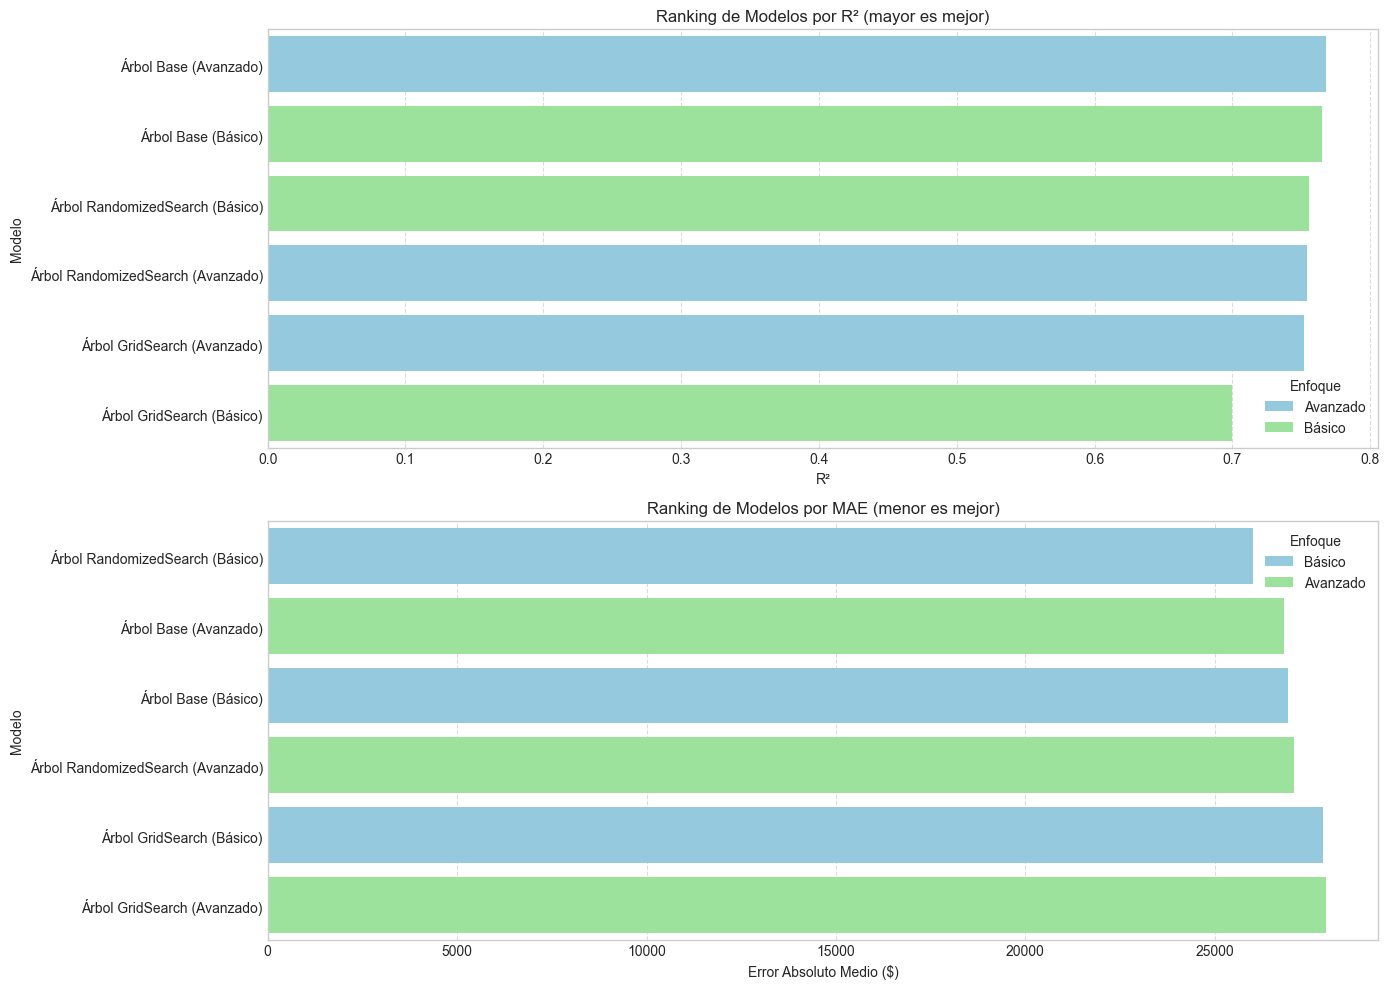

In [73]:
# Crear un DataFrame con todos los modelos y sus métricas
all_models = [
    # Enfoque básico
    ('Árbol Base (Básico)', mean_absolute_error(y_test_original, dt_pred_original), 
     mean_squared_error(y_test_original, dt_pred_original), r2_score(y_test, dt_pred), 'Básico'),
    
    ('Árbol RandomizedSearch (Básico)', mean_absolute_error(y_test_original, dt_random_pred_original), 
     mean_squared_error(y_test_original, dt_random_pred_original), r2_score(y_test, dt_random_pred), 'Básico'),
    
    ('Árbol GridSearch (Básico)', mean_absolute_error(y_test_original, dt_grid_pred_original), 
     mean_squared_error(y_test_original, dt_grid_pred_original), r2_score(y_test, dt_grid_pred), 'Básico'),
    
    # Enfoque avanzado
    ('Árbol Base (Avanzado)', mean_absolute_error(y_test_original_adv, dt_pred_original_adv), 
     mean_squared_error(y_test_original_adv, dt_pred_original_adv), r2_score(y_test_adv, dt_pred_adv), 'Avanzado'),
    
    ('Árbol RandomizedSearch (Avanzado)', mean_absolute_error(y_test_original_adv, dt_random_pred_original_adv), 
     mean_squared_error(y_test_original_adv, dt_random_pred_original_adv), r2_score(y_test_adv, dt_random_pred_adv), 'Avanzado'),
    
    ('Árbol GridSearch (Avanzado)', mean_absolute_error(y_test_original_adv, dt_grid_pred_original_adv), 
     mean_squared_error(y_test_original_adv, dt_grid_pred_original_adv), r2_score(y_test_adv, dt_grid_pred_adv), 'Avanzado')
]

ranking_df = pd.DataFrame(all_models, columns=['Modelo', 'MAE', 'MSE', 'R²', 'Enfoque'])

# Calcular RMSE a partir de MSE
ranking_df['RMSE'] = np.sqrt(ranking_df['MSE'])

# Ordenar por R² descendente (mejor modelo primero)
ranking_df_r2 = ranking_df.sort_values('R²', ascending=False).reset_index(drop=True)
ranking_df_r2.index += 1  # Ajustar índice para que empiece en 1

# Ordenar por MAE ascendente (mejor modelo primero)
ranking_df_mae = ranking_df.sort_values('MAE').reset_index(drop=True)
ranking_df_mae.index += 1  # Ajustar índice para que empiece en 1

# Mostrar rankings
print("Ranking de Modelos por R² (mayor es mejor):")
display(ranking_df_r2[['Modelo', 'R²', 'MAE', 'RMSE', 'Enfoque']])

print("\nRanking de Modelos por MAE (menor es mejor):")
display(ranking_df_mae[['Modelo', 'MAE', 'RMSE', 'R²', 'Enfoque']])

# Identificar el mejor modelo general
mejor_modelo = ranking_df_r2.iloc[0]['Modelo']
mejor_r2 = ranking_df_r2.iloc[0]['R²']
mejor_mae = ranking_df_r2.iloc[0]['MAE']
mejor_rmse = ranking_df_r2.iloc[0]['RMSE']
mejor_enfoque = ranking_df_r2.iloc[0]['Enfoque']

print(f"\nEl mejor modelo general es: {mejor_modelo}")
print(f"  • R²: {mejor_r2:.4f}")
print(f"  • MAE: ${mejor_mae:.2f}")
print(f"  • RMSE: ${mejor_rmse:.2f}")
print(f"  • Enfoque: {mejor_enfoque}")

# Visualizar el ranking
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='R²', y='Modelo', data=ranking_df_r2, hue='Enfoque', palette=['skyblue', 'lightgreen'])
plt.title('Ranking de Modelos por R² (mayor es mejor)')
plt.xlabel('R²')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
sns.barplot(x='MAE', y='Modelo', data=ranking_df_mae, hue='Enfoque', palette=['skyblue', 'lightgreen'])
plt.title('Ranking de Modelos por MAE (menor es mejor)')
plt.xlabel('Error Absoluto Medio ($)')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Evaluando el Mejor Modelo de Predicción

En el caso de la predicción de precios inmobiliarios, se determinó que el **Árbol Base (Avanzado)** es el mejor modelo en general. Analicemos por qué y qué implica cada métrica.

## ¿Por qué se eligió este modelo?

Este modelo fue seleccionado principalmente por tener el **R² más alto (0.7676)**, aunque no tiene el MAE más bajo. Esto representa una decisión de equilibrio entre diferentes métricas de evaluación.

## Métricas clave y su importancia

### R² (Coeficiente de determinación)
- **Qué mide**: Qué porcentaje de la variación en los precios puede explicar el modelo
- **Interpretación**: Un valor de 0.7676 significa que el modelo explica aproximadamente el 77% de la variabilidad en los precios
- **Importancia**: Indica qué tan bien el modelo captura los patrones generales de los datos

### MAE (Error Absoluto Medio)
- **Qué mide**: El error promedio en dólares (sin importar si son sobrestimaciones o subestimaciones)
- **Interpretación**: Un valor de $26,825 significa que, en promedio, las predicciones se desvían por esa cantidad
- **Importancia**: Es fácil de interpretar en términos de la unidad original (dólares)

### RMSE (Raíz del Error Cuadrático Medio)
- **Qué mide**: Similar al MAE, pero penaliza más los errores grandes
- **Interpretación**: Un valor de $41,995 indica la magnitud del error con mayor sensibilidad a errores grandes
- **Importancia**: Útil cuando errores grandes son especialmente problemáticos

## ¿Qué se prioriza y por qué?

### Escenarios donde priorizar R²:
- **Cuando necesitas entender tendencias generales**: Si quieres un modelo que capture bien los patrones del mercado
- **Ejemplo simple**: Un inversionista que quiere entender qué factores determinan los precios de viviendas en diferentes vecindarios

### Escenarios donde priorizar MAE:
- **Cuando el error absoluto en dólares es crucial**: Si necesitas precisión en términos monetarios concretos
- **Ejemplo simple**: Un tasador que necesita estimar el valor de una propiedad y donde cada dólar de desviación importa

### Escenarios donde priorizar RMSE:
- **Cuando errores grandes son muy costosos**: Si es más importante evitar predicciones extremadamente incorrectas
- **Ejemplo simple**: Un banco otorgando préstamos hipotecarios donde una sobrestimación grande del valor podría resultar en pérdidas significativas

## Por qué el modelo Árbol Base (Avanzado) es considerado el mejor:

Este modelo ofrece el mejor equilibrio entre:
1. **Alta capacidad explicativa** (mejor R²)
2. **Error monetario razonable** (segundo mejor MAE)
3. **Buen control de errores extremos** (buen RMSE)

Para predicción de precios inmobiliarios, es valioso tener un modelo que explique bien la variabilidad de los precios (alto R²) mientras mantiene errores monetarios aceptables.